**notebook version**: `3` (4 Jul 2024)  
**new in this version**: added check if downloaded data is indeed in 30MIN time resolution

- This notebook can be used to download data from the database `InfluxDB`
- Data are stored to a `.csv` file in this folder

</br>

# **Auto-settings**

## Data settings

In [1]:
DIRCONF = r'L:\Sync\luhk_work\20 - CODING\22 - POET\configs'
# DIRCONF = r'P:\Flux\RDS_calculations\_scripts\_configs\configs'  # Folder with configuration files: needed e.g. for connection to database
TIMEZONE_OFFSET_TO_UTC_HOURS = 1  # Timezone, e.g. "1" is translated to timezone "UTC+01:00" (CET, winter time)
REQUIRED_TIME_RESOLUTION = '30min'  # 30MIN time resolution

## Imports

In [2]:
import importlib.metadata
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from diive.core.io.files import save_parquet

sns.set_theme('notebook')
from diive.core.plotting.timeseries import TimeSeries
from dbc_influxdb import dbcInflux
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.core.times.times import TimestampSanitizer
from diive.pkgs.createvar.potentialradiation import potrad
from diive.pkgs.gapfilling.xgboost_ts import XGBoostTS
from diive.core.io.files import load_parquet
import warnings

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")
version_dbc = importlib.metadata.version("dbc_influxdb")
print(f"dbc-influxdb version: v{version_dbc}")
dbc = dbcInflux(dirconf=DIRCONF)  # Connect to database

diive version: v0.85.0
dbc-influxdb version: v0.12.0
Reading configuration files was successful.
Connection to database works.


</br>

# **LOAD DATA** from files

In [3]:
filename_data_simple_2005_2024 = "15.1_CH-CHA_meteo6_2005-2024.parquet"
data_simple_2005_2024 = load_parquet(filepath=filename_data_simple_2005_2024)
data_simple_2005_2024

Loaded .parquet file 15.1_CH-CHA_meteo6_2005-2024.parquet (0.066 seconds).
    --> Detected time resolution of <30 * Minutes> / 30min 


G_GF1_0.03_1  LW_IN_T1_2_1  LW_OUT_T1_2_1  PA_GF1_0.9_1  FLAG_PA_GF1_0.9_1_ISFILLED  PPFD_IN_T1_2_2  ...  SW_OUT_T1_2_1  TA_T1_2_1  FLAG_TA_T1_2_1_ISFILLED  TS_GF1_0.04_1  TS_GF1_0.15_1  TS_GF1_0.4_1
TIMESTAMP_MIDDLE                                                                                                          ...                                                                                               
2005-01-01 00:15:00           NaN           NaN            NaN    978.100000                         1.0             NaN  ...            NaN   1.566667                      3.0            NaN            NaN           NaN
2005-01-01 00:45:00           NaN           NaN            NaN    977.933333                         1.0             NaN  ...            NaN   1.533333                      3.0            NaN            NaN           NaN
2005-01-01 01:15:00           NaN           NaN            NaN    977.900000                         1.0             NaN  ...            NaN   1.566667                      3.0            NaN            NaN           NaN
2005-01-01 01:45:00           NaN           NaN            NaN    977.833333                         1.0             NaN  ...            NaN   1.566667                      3.0            NaN            NaN           NaN
2005-01-01 02:15:00           NaN           NaN            NaN    977.833333                         1.0             NaN  ...            NaN   1.500000                      3.0            NaN            NaN           NaN
...                           ...           ...            ...           ...                         ...             ...  ...            ...        ...                      ...            ...            ...           ...
2024-12-31 21:45:00           NaN    304.613900            NaN    983.370890                         NaN             0.0  ...            NaN  -1.919472                      NaN            NaN            NaN           NaN
2024-12-31 22:15:00           NaN    303.039890            NaN    983.052160                         NaN             0.0  ...            NaN  -2.104678                      NaN            NaN            NaN           NaN
2024-12-31 22:45:00           NaN    302.093633            NaN    982.851140                         NaN             0.0  ...            NaN  -2.089444                      NaN            NaN            NaN           NaN
2024-12-31 23:15:00           NaN    302.217307            NaN    982.896827                         NaN             0.0  ...            NaN  -2.355761                      NaN            NaN            NaN           NaN
2024-12-31 23:45:00           NaN    298.392973            NaN    982.856613                         NaN             0.0  ...            NaN  -2.578839                      NaN            NaN            NaN           NaN

[350640 rows x 21 columns]

</br>

## Plot

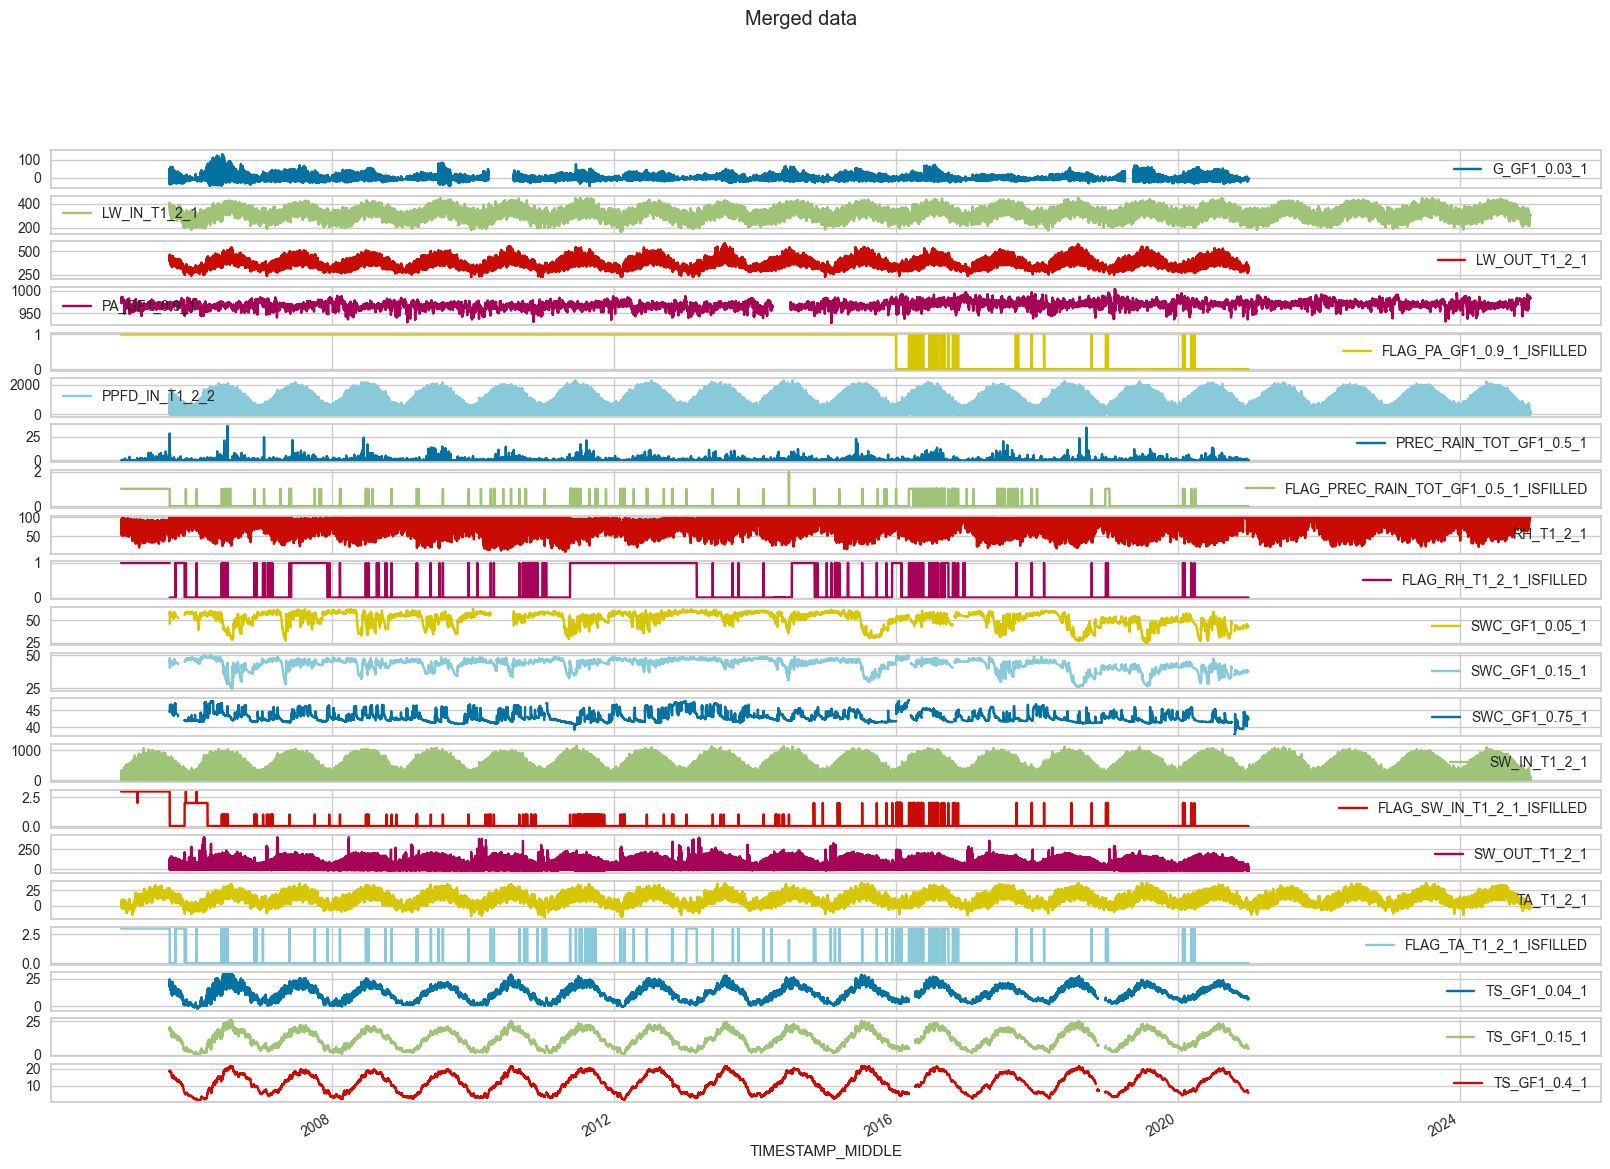

In [5]:
data_simple_2005_2024.plot(subplots=True, x_compat=True, title="Merged data", figsize=(20, 14));

# **Gap-filling**

## SW_IN

In [7]:
_df = pd.DataFrame()
_df['SW_IN_T1_2_1'] = data_simple_2005_2024[['SW_IN_T1_2_1']].copy()
_df['SW_IN_POT'] = potrad(timestamp_index=_df.index,
                          lat=47.210227,  # CH-CHA
                          lon=8.410645,  # CH-CHA
                          utc_offset=1)
_df

SW_IN_T1_2_1  SW_IN_POT
TIMESTAMP_MIDDLE                            
2005-01-01 00:15:00           3.0        0.0
2005-01-01 00:45:00           3.0        0.0
2005-01-01 01:15:00           3.0        0.0
2005-01-01 01:45:00           3.0        0.0
2005-01-01 02:15:00           0.0        0.0
...                           ...        ...
2024-12-31 21:45:00           0.0        0.0
2024-12-31 22:15:00           0.0        0.0
2024-12-31 22:45:00           0.0        0.0
2024-12-31 23:15:00           0.0        0.0
2024-12-31 23:45:00           0.0        0.0

[350640 rows x 2 columns]

### Set nighttime data to zero

In [9]:
# Detect nighttime
from diive.pkgs.createvar.daynightflag import DaytimeNighttimeFlag
dnf = DaytimeNighttimeFlag(
    timestamp_index=_df.index,
    nighttime_threshold=0.001,
    lat=47.210227,  # CH-CHA
    lon=8.410645,  # CH-CHA
    utc_offset=1)
nighttimeflag = dnf.get_nighttime_flag()
nighttime_ix = nighttimeflag == 1

Some nighttime data is above or below zero:

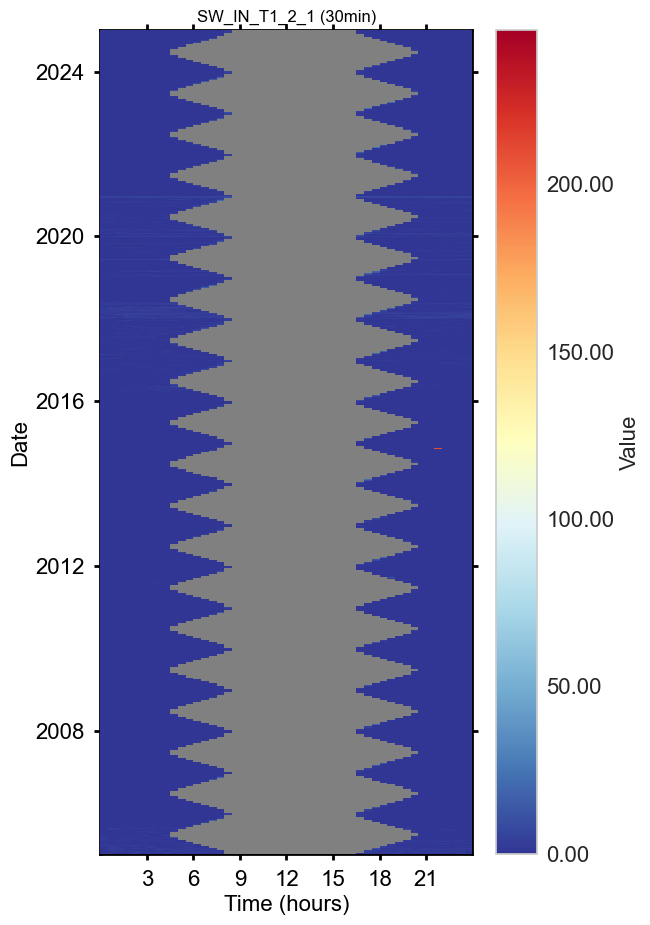

In [10]:
HeatmapDateTime(_df.loc[nighttime_ix, 'SW_IN_T1_2_1']).plot()

In [11]:
_df.loc[nighttime_ix, 'SW_IN_T1_2_1'].describe()

count    175280.000000
mean          0.281561
std           1.762171
min          -0.158850
25%           0.000000
50%           0.000000
75%           0.000000
max         246.000000
Name: SW_IN_T1_2_1, dtype: float64

In [12]:
_df.loc[nighttime_ix, 'SW_IN_T1_2_1'] = 0
_df.loc[nighttime_ix, 'SW_IN_T1_2_1'].describe()

count    175280.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: SW_IN_T1_2_1, dtype: float64

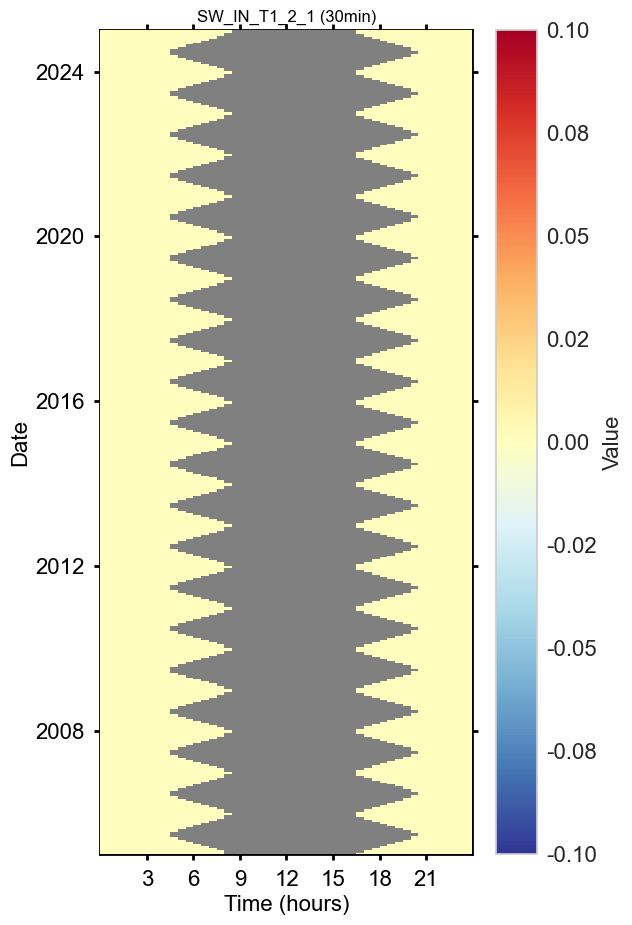

In [13]:
HeatmapDateTime(_df.loc[nighttime_ix, 'SW_IN_T1_2_1']).plot()

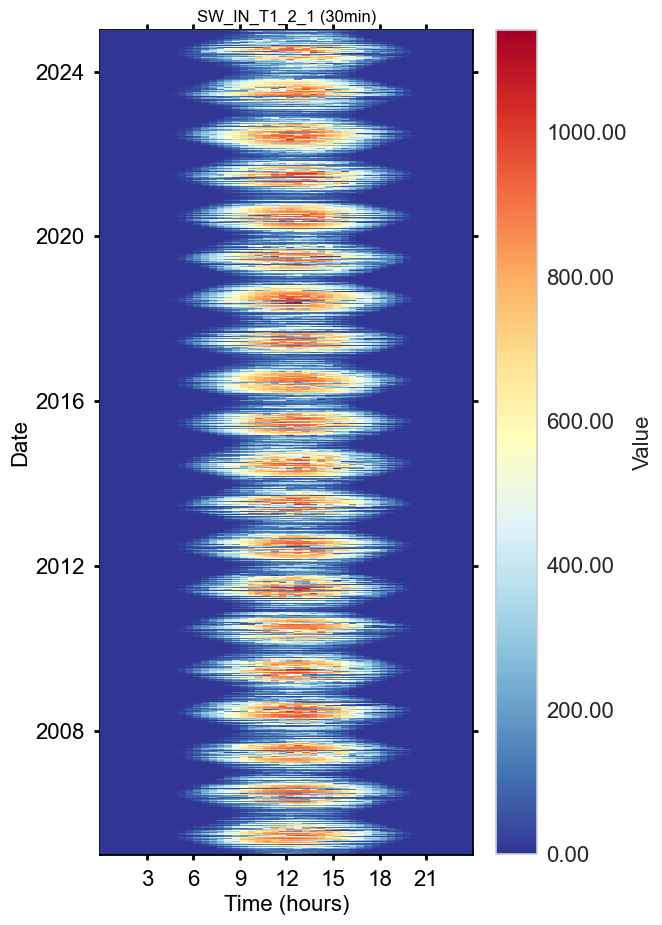

In [14]:
HeatmapDateTime(_df['SW_IN_T1_2_1']).plot()

### Fill

In [15]:
xgb = XGBoostTS(
    input_df=_df,
    target_col='SW_IN_T1_2_1',
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 350640.


In [16]:
xgb.reduce_features()
xgb.report_feature_reduction()


Feature reduction based on permutation importance ...
[0]	validation_0-rmse:185.09994	validation_1-rmse:185.09994
[1]	validation_0-rmse:154.12846	validation_1-rmse:154.12846
[2]	validation_0-rmse:136.30653	validation_1-rmse:136.30653
[3]	validation_0-rmse:126.53401	validation_1-rmse:126.53401
[4]	validation_0-rmse:121.24482	validation_1-rmse:121.24482
[5]	validation_0-rmse:118.42406	validation_1-rmse:118.42406
[6]	validation_0-rmse:116.93448	validation_1-rmse:116.93448
[7]	validation_0-rmse:115.92969	validation_1-rmse:115.92969
[8]	validation_0-rmse:115.23145	validation_1-rmse:115.23145
[9]	validation_0-rmse:114.63395	validation_1-rmse:114.63395
[10]	validation_0-rmse:114.28162	validation_1-rmse:114.28162
[11]	validation_0-rmse:113.73770	validation_1-rmse:113.73770
[12]	validation_0-rmse:113.32689	validation_1-rmse:113.32689
[13]	validation_0-rmse:113.19577	validation_1-rmse:113.19577
[14]	validation_0-rmse:112.96676	validation_1-rmse:112.96676
[15]	validation_0-rmse:112.73606	validat

In [17]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2005-01-01 00:45:00 and 2024-12-31 23:45:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:185.11802	validation_1-rmse:184.35022
[1]	validation_0-rmse:154.17017	validation_1-rmse:153.54128
[2]	validation_0-rmse:136.36258	validation_1-rmse:135.88500
[3]	validation_0-rmse:126.52564	validation_1-rmse:126.15580
[4]	validation_0-rmse:121.27460	validation_1-rmse:121.04368
[5]	validation_0-rmse:118.47730	validation_1-rmse:118.38885
[6]	validation_0-rmse:116.98657	validation_1-rmse:116.91071
[7]	validation_0-rmse:115.93105	validation_1-rmse:115.93634
[8]	validation_0-rmse:115.26781	validation_1-rmse:115.35900
[9]	validation_0-rmse:114.90300	validation_1-rmse:115.02270
[10]	validation_0-rmse:114.39260	validation_1-rmse:114.55386
[11]	validation_0-rmse:113.90200	validation_1-rmse:114.10400
[12]	validation_0-rmse:113.58487	validation_1-rmse:113.81515
[13]	validation_0-rmse:1

In [18]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()


Gap-filling using final model ...
>>> Using final model on all data to predict target SW_IN_T1_2_1 ...
>>> Using final model on all data to calculate permutation importance ...
>>> Calculating prediction scores based on all data predicting SW_IN_T1_2_1 ...
>>> Predicting target SW_IN_T1_2_1 where all features are available ... predicted 350640 records.
>>> Collecting results for final model ...
>>> Filling 25 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable SW_IN_T1_2_1_gfXG ...
>>> Restoring original timestamp in results ...
>>> Combining predictions from full model and fallback model ...

GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (25 values, SW_IN_T1_2_1_gfXG where flag=1) in comparison to observed targets (350615 values, SW_IN_T1_2_1).

## TARGET
- first timestamp:  2005-01-01 00:15:00
- last timestamp:  2024-12-31 23:45:00
- potential number of values: 

### Results

In [19]:
results = xgb.gapfilling_df_
results

.PREDICTIONS_FULLMODEL  SW_IN_T1_2_1  .GAP_PREDICTIONS  FLAG_SW_IN_T1_2_1_gfXG_ISFILLED  SW_IN_T1_2_1_gfXG .PREDICTIONS_FALLBACK  .GAPFILLED_CUMULATIVE  .PREDICTIONS
TIMESTAMP_MIDDLE                                                                                                                                                                          
2005-01-01 00:15:00               -1.159734           0.0               NaN                                0                0.0                  None           0.000000e+00     -1.159734
2005-01-01 00:45:00               -1.159734           0.0               NaN                                0                0.0                  None           0.000000e+00     -1.159734
2005-01-01 01:15:00               -1.159734           0.0               NaN                                0                0.0                  None           0.000000e+00     -1.159734
2005-01-01 01:45:00               -1.159734           0.0               NaN                                0                0.0                  None           0.000000e+00     -1.159734
2005-01-01 02:15:00               -1.159734           0.0               NaN                                0                0.0                  None           0.000000e+00     -1.159734
...                                     ...           ...               ...                              ...                ...                   ...                    ...           ...
2024-12-31 21:45:00               -0.738784           0.0               NaN                                0                0.0                  None           4.988461e+07     -0.738784
2024-12-31 22:15:00               -0.738784           0.0               NaN                                0                0.0                  None           4.988461e+07     -0.738784
2024-12-31 22:45:00               -0.738784           0.0               NaN                                0                0.0                  None           4.988461e+07     -0.738784
2024-12-31 23:15:00               -0.738784           0.0               NaN                                0                0.0                  None           4.988461e+07     -0.738784
2024-12-31 23:45:00               -0.738784           0.0               NaN                                0                0.0                  None           4.988461e+07     -0.738784

[350640 rows x 8 columns]

### Add to data

In [20]:
# Combine data
data_simple_2005_2024['SW_IN_T1_2_1'] = results['SW_IN_T1_2_1_gfXG'].copy()
data_simple_2005_2024['SW_IN_T1_2_1']

TIMESTAMP_MIDDLE
2005-01-01 00:15:00    0.0
2005-01-01 00:45:00    0.0
2005-01-01 01:15:00    0.0
2005-01-01 01:45:00    0.0
2005-01-01 02:15:00    0.0
                      ... 
2024-12-31 21:45:00    0.0
2024-12-31 22:15:00    0.0
2024-12-31 22:45:00    0.0
2024-12-31 23:15:00    0.0
2024-12-31 23:45:00    0.0
Freq: 30min, Name: SW_IN_T1_2_1, Length: 350640, dtype: float64

In [21]:
# Combine flags
data_simple_2005_2024['FLAG_SW_IN_T1_2_1_ISFILLED'] = data_simple_2005_2024['FLAG_SW_IN_T1_2_1_ISFILLED'].combine_first(results['FLAG_SW_IN_T1_2_1_gfXG_ISFILLED'])
data_simple_2005_2024['FLAG_SW_IN_T1_2_1_ISFILLED']

TIMESTAMP_MIDDLE
2005-01-01 00:15:00    3.0
2005-01-01 00:45:00    3.0
2005-01-01 01:15:00    3.0
2005-01-01 01:45:00    3.0
2005-01-01 02:15:00    3.0
                      ... 
2024-12-31 21:45:00    0.0
2024-12-31 22:15:00    0.0
2024-12-31 22:45:00    0.0
2024-12-31 23:15:00    0.0
2024-12-31 23:45:00    0.0
Freq: 30min, Name: FLAG_SW_IN_T1_2_1_ISFILLED, Length: 350640, dtype: float64

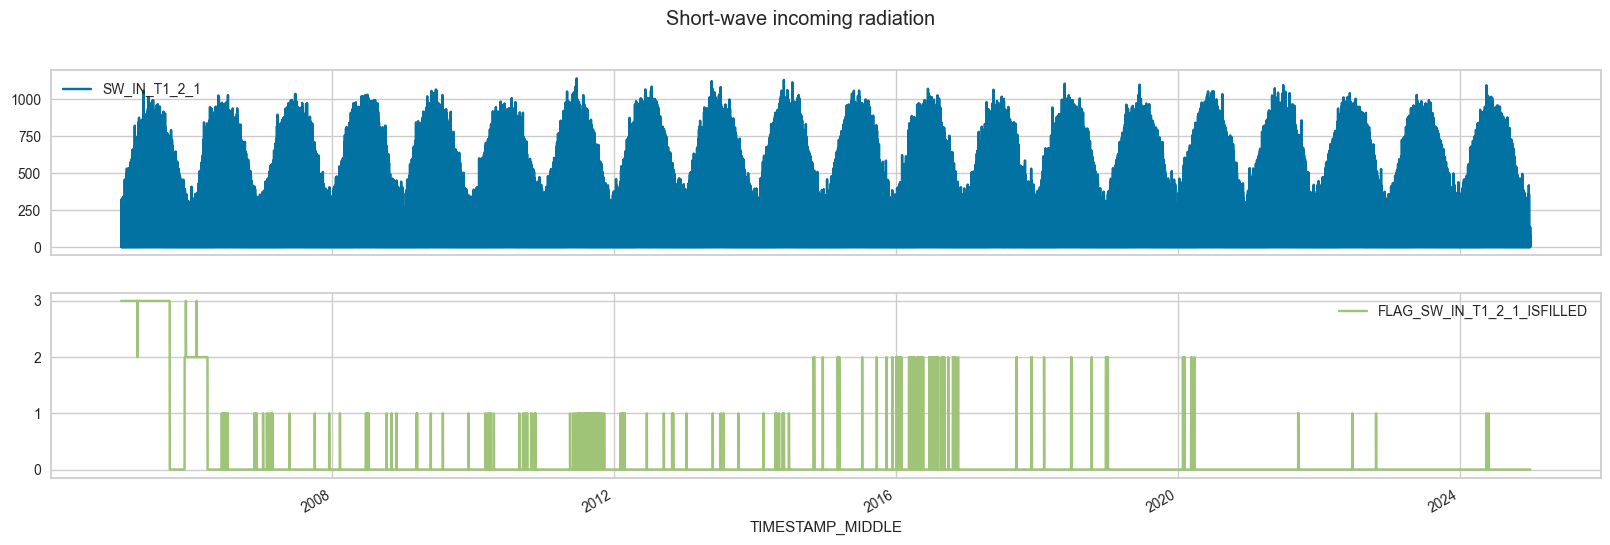

In [22]:
title = "Short-wave incoming radiation"
data_simple_2005_2024[['SW_IN_T1_2_1', 'FLAG_SW_IN_T1_2_1_ISFILLED']].plot(x_compat=True, title=title, subplots=True, figsize=(20, 6));

</br>

## TA

In [23]:
_df = pd.DataFrame()
_df['SW_IN_T1_2_1'] = data_simple_2005_2024['SW_IN_T1_2_1'].copy()
_df['TA_T1_2_1'] = data_simple_2005_2024['TA_T1_2_1'].copy()
_df

SW_IN_T1_2_1  TA_T1_2_1
TIMESTAMP_MIDDLE                            
2005-01-01 00:15:00           0.0   1.566667
2005-01-01 00:45:00           0.0   1.533333
2005-01-01 01:15:00           0.0   1.566667
2005-01-01 01:45:00           0.0   1.566667
2005-01-01 02:15:00           0.0   1.500000
...                           ...        ...
2024-12-31 21:45:00           0.0  -1.919472
2024-12-31 22:15:00           0.0  -2.104678
2024-12-31 22:45:00           0.0  -2.089444
2024-12-31 23:15:00           0.0  -2.355761
2024-12-31 23:45:00           0.0  -2.578839

[350640 rows x 2 columns]

### Fill

In [24]:
xgb = XGBoostTS(
    input_df=_df,
    target_col='TA_T1_2_1',
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 350640.


In [25]:
xgb.reduce_features()
xgb.report_feature_reduction()


Feature reduction based on permutation importance ...
[0]	validation_0-rmse:6.58013	validation_1-rmse:6.58013
[1]	validation_0-rmse:5.36035	validation_1-rmse:5.36035
[2]	validation_0-rmse:4.60877	validation_1-rmse:4.60877
[3]	validation_0-rmse:4.13898	validation_1-rmse:4.13898
[4]	validation_0-rmse:3.85629	validation_1-rmse:3.85629
[5]	validation_0-rmse:3.68049	validation_1-rmse:3.68049
[6]	validation_0-rmse:3.57062	validation_1-rmse:3.57062
[7]	validation_0-rmse:3.49049	validation_1-rmse:3.49049
[8]	validation_0-rmse:3.43829	validation_1-rmse:3.43829
[9]	validation_0-rmse:3.39443	validation_1-rmse:3.39443
[10]	validation_0-rmse:3.36784	validation_1-rmse:3.36784
[11]	validation_0-rmse:3.34869	validation_1-rmse:3.34869
[12]	validation_0-rmse:3.31166	validation_1-rmse:3.31166
[13]	validation_0-rmse:3.28019	validation_1-rmse:3.28019
[14]	validation_0-rmse:3.26258	validation_1-rmse:3.26258
[15]	validation_0-rmse:3.24914	validation_1-rmse:3.24914
[16]	validation_0-rmse:3.23781	validation_1

In [26]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2005-01-01 00:45:00 and 2024-12-31 23:15:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:6.58013	validation_1-rmse:6.54892
[1]	validation_0-rmse:5.36035	validation_1-rmse:5.34068
[2]	validation_0-rmse:4.60877	validation_1-rmse:4.59894
[3]	validation_0-rmse:4.13898	validation_1-rmse:4.13697
[4]	validation_0-rmse:3.85629	validation_1-rmse:3.86163
[5]	validation_0-rmse:3.68049	validation_1-rmse:3.69165
[6]	validation_0-rmse:3.57062	validation_1-rmse:3.58579
[7]	validation_0-rmse:3.49049	validation_1-rmse:3.50914
[8]	validation_0-rmse:3.43830	validation_1-rmse:3.46077
[9]	validation_0-rmse:3.39444	validation_1-rmse:3.41779
[10]	validation_0-rmse:3.36785	validation_1-rmse:3.39268
[11]	validation_0-rmse:3.34869	validation_1-rmse:3.37643
[12]	validation_0-rmse:3.31167	validation_1-rmse:3.33997
[13]	validation_0-rmse:3.28020	validation_1-rmse:3.31099
[14]	validation_0-r

In [27]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()


Gap-filling using final model ...
>>> Using final model on all data to predict target TA_T1_2_1 ...
>>> Using final model on all data to calculate permutation importance ...
>>> Calculating prediction scores based on all data predicting TA_T1_2_1 ...
>>> Predicting target TA_T1_2_1 where all features are available ... predicted 350640 records.
>>> Collecting results for final model ...
>>> Filling 193 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable TA_T1_2_1_gfXG ...
>>> Restoring original timestamp in results ...
>>> Combining predictions from full model and fallback model ...

GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (193 values, TA_T1_2_1_gfXG where flag=1) in comparison to observed targets (350447 values, TA_T1_2_1).

## TARGET
- first timestamp:  2005-01-01 00:15:00
- last timestamp:  2024-12-31 23:45:00
- potential number of values: 350640 values)
-

### Results

In [28]:
results = xgb.gapfilling_df_
results

.PREDICTIONS_FULLMODEL  TA_T1_2_1  .GAP_PREDICTIONS  FLAG_TA_T1_2_1_gfXG_ISFILLED  TA_T1_2_1_gfXG .PREDICTIONS_FALLBACK  .GAPFILLED_CUMULATIVE  .PREDICTIONS
TIMESTAMP_MIDDLE                                                                                                                                                                 
2005-01-01 00:15:00                3.541210   1.566667               NaN                             0        1.566667                  None           1.566667e+00      3.541210
2005-01-01 00:45:00                3.541210   1.533333               NaN                             0        1.533333                  None           3.100000e+00      3.541210
2005-01-01 01:15:00                3.764976   1.566667               NaN                             0        1.566667                  None           4.666667e+00      3.764976
2005-01-01 01:45:00                3.764976   1.566667               NaN                             0        1.566667                  None           6.233333e+00      3.764976
2005-01-01 02:15:00                2.921293   1.500000               NaN                             0        1.500000                  None           7.733333e+00      2.921293
...                                     ...        ...               ...                           ...             ...                   ...                    ...           ...
2024-12-31 21:45:00               -2.075586  -1.919472               NaN                             0       -1.919472                  None           3.502278e+06     -2.075586
2024-12-31 22:15:00               -2.026122  -2.104678               NaN                             0       -2.104678                  None           3.502276e+06     -2.026122
2024-12-31 22:45:00               -2.026122  -2.089444               NaN                             0       -2.089444                  None           3.502274e+06     -2.026122
2024-12-31 23:15:00               -2.331489  -2.355761               NaN                             0       -2.355761                  None           3.502272e+06     -2.331489
2024-12-31 23:45:00               -2.331489  -2.578839               NaN                             0       -2.578839                  None           3.502269e+06     -2.331489

[350640 rows x 8 columns]

### Add to data

In [29]:
# Combine data
data_simple_2005_2024['TA_T1_2_1'] = results['TA_T1_2_1_gfXG'].copy()
data_simple_2005_2024['TA_T1_2_1']

TIMESTAMP_MIDDLE
2005-01-01 00:15:00    1.566667
2005-01-01 00:45:00    1.533333
2005-01-01 01:15:00    1.566667
2005-01-01 01:45:00    1.566667
2005-01-01 02:15:00    1.500000
                         ...   
2024-12-31 21:45:00   -1.919472
2024-12-31 22:15:00   -2.104678
2024-12-31 22:45:00   -2.089444
2024-12-31 23:15:00   -2.355761
2024-12-31 23:45:00   -2.578839
Freq: 30min, Name: TA_T1_2_1, Length: 350640, dtype: float64

In [30]:
# Combine flags
data_simple_2005_2024['FLAG_TA_T1_2_1_ISFILLED'] = data_simple_2005_2024['FLAG_TA_T1_2_1_ISFILLED'].combine_first(results['FLAG_TA_T1_2_1_gfXG_ISFILLED'])
data_simple_2005_2024['FLAG_TA_T1_2_1_ISFILLED']

TIMESTAMP_MIDDLE
2005-01-01 00:15:00    3.0
2005-01-01 00:45:00    3.0
2005-01-01 01:15:00    3.0
2005-01-01 01:45:00    3.0
2005-01-01 02:15:00    3.0
                      ... 
2024-12-31 21:45:00    0.0
2024-12-31 22:15:00    0.0
2024-12-31 22:45:00    0.0
2024-12-31 23:15:00    0.0
2024-12-31 23:45:00    0.0
Freq: 30min, Name: FLAG_TA_T1_2_1_ISFILLED, Length: 350640, dtype: float64

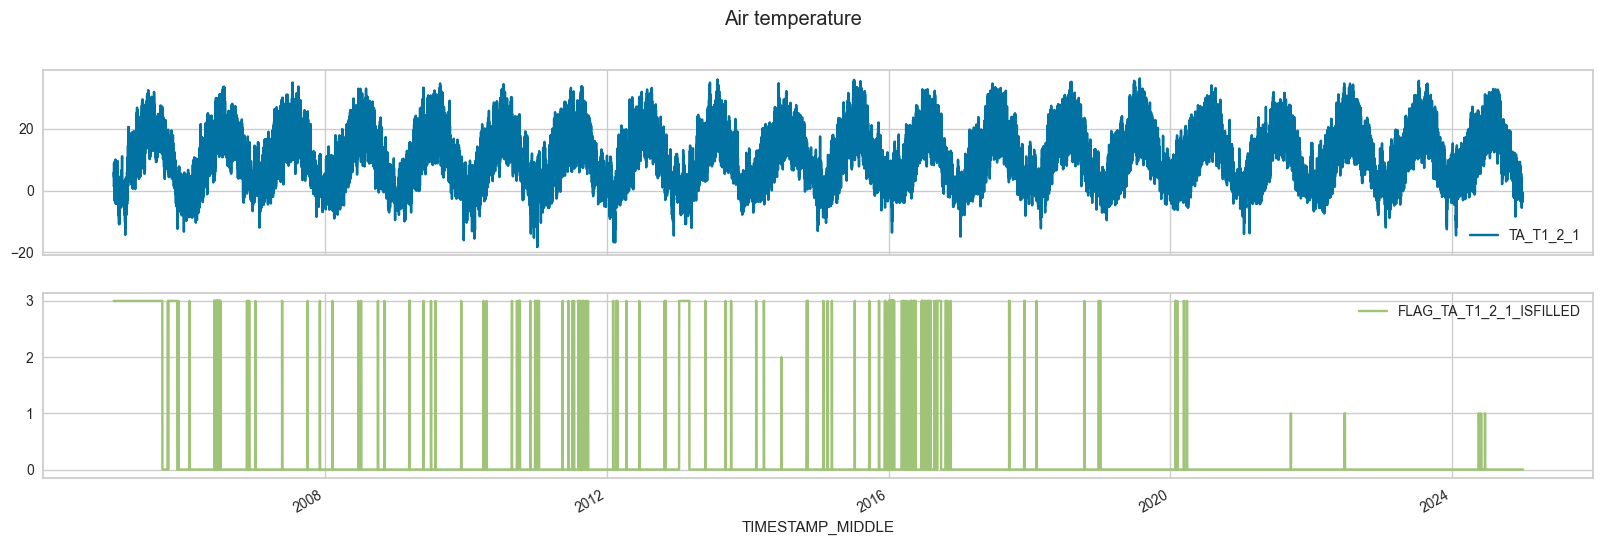

In [31]:
title = "Air temperature"
data_simple_2005_2024[['TA_T1_2_1', 'FLAG_TA_T1_2_1_ISFILLED']].plot(x_compat=True, title=title, subplots=True, figsize=(20, 6));

</br>

## PPFD

In [32]:
_df = pd.DataFrame()
_df['PPFD_IN_T1_2_2'] = data_simple_2005_2024[['PPFD_IN_T1_2_2']].copy()
_df['SW_IN_T1_2_1'] = data_simple_2005_2024[['SW_IN_T1_2_1']].copy()
_df

PPFD_IN_T1_2_2  SW_IN_T1_2_1
TIMESTAMP_MIDDLE                                 
2005-01-01 00:15:00             NaN           0.0
2005-01-01 00:45:00             NaN           0.0
2005-01-01 01:15:00             NaN           0.0
2005-01-01 01:45:00             NaN           0.0
2005-01-01 02:15:00             NaN           0.0
...                             ...           ...
2024-12-31 21:45:00             0.0           0.0
2024-12-31 22:15:00             0.0           0.0
2024-12-31 22:45:00             0.0           0.0
2024-12-31 23:15:00             0.0           0.0
2024-12-31 23:45:00             0.0           0.0

[350640 rows x 2 columns]

### Set nighttime data to zero

In [33]:
# Detect nighttime
from diive.pkgs.createvar.daynightflag import DaytimeNighttimeFlag
dnf = DaytimeNighttimeFlag(
    timestamp_index=_df.index,    
    lat=47.210227,  # CH-CHA
    lon=8.410645,  # CH-CHA
    utc_offset=1,
    nighttime_threshold=0.001)
nighttimeflag = dnf.get_nighttime_flag()
nighttime_ix = nighttimeflag == 1

Some nighttime data is above or below zero:

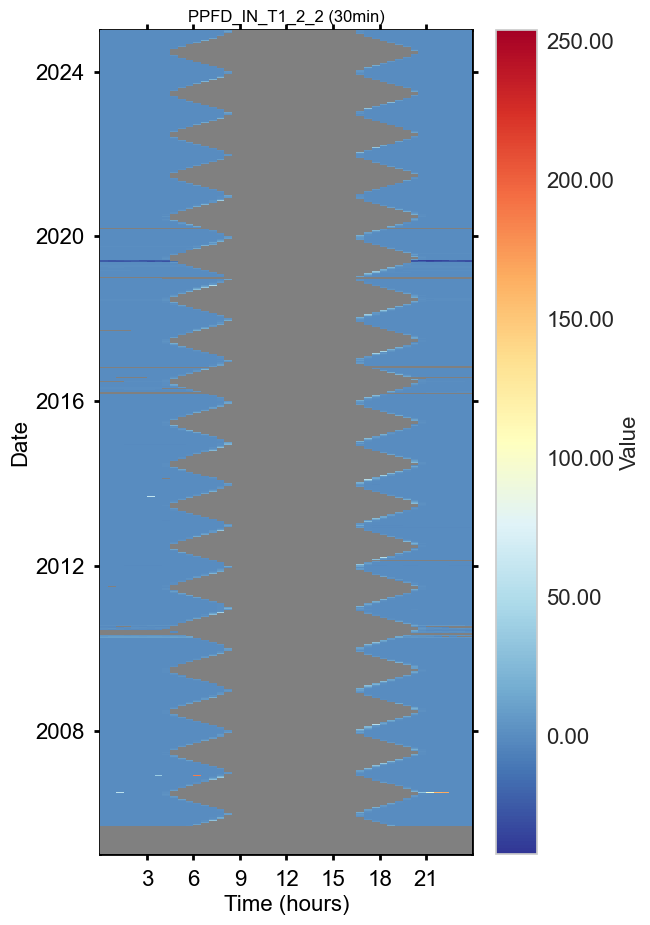

In [34]:
HeatmapDateTime(_df.loc[nighttime_ix, 'PPFD_IN_T1_2_2']).plot()

In [35]:
_df.loc[nighttime_ix, 'PPFD_IN_T1_2_2'].describe()

count    167652.000000
mean          0.346994
std           3.748432
min         -42.389820
25%          -0.168090
50%           0.000000
75%           0.000000
max         254.000000
Name: PPFD_IN_T1_2_2, dtype: float64

In [36]:
_df.loc[nighttime_ix, 'PPFD_IN_T1_2_2'] = 0
_df.loc[nighttime_ix, 'PPFD_IN_T1_2_2'].describe()

count    175280.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: PPFD_IN_T1_2_2, dtype: float64

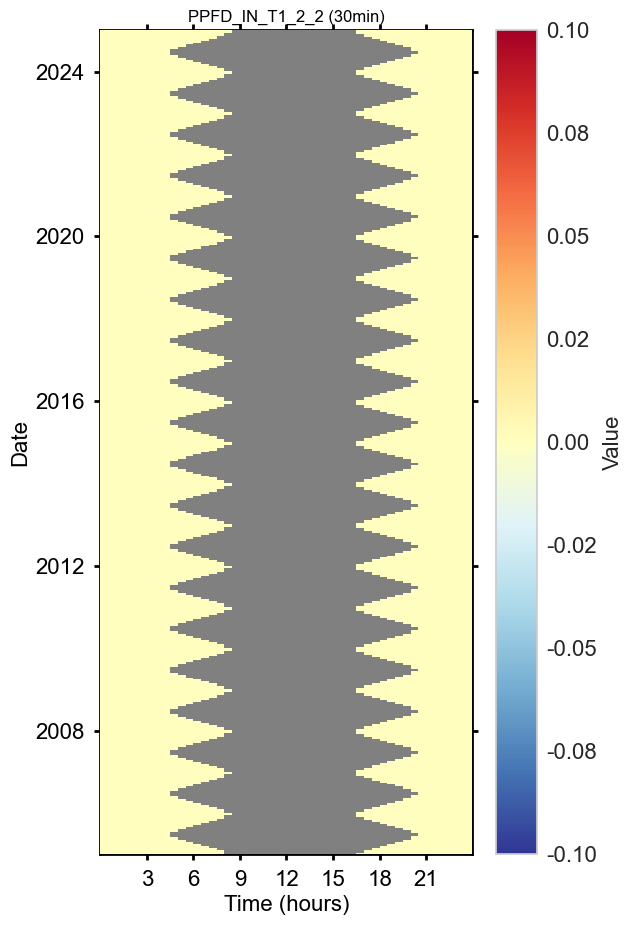

In [37]:
HeatmapDateTime(_df.loc[nighttime_ix, 'PPFD_IN_T1_2_2']).plot()

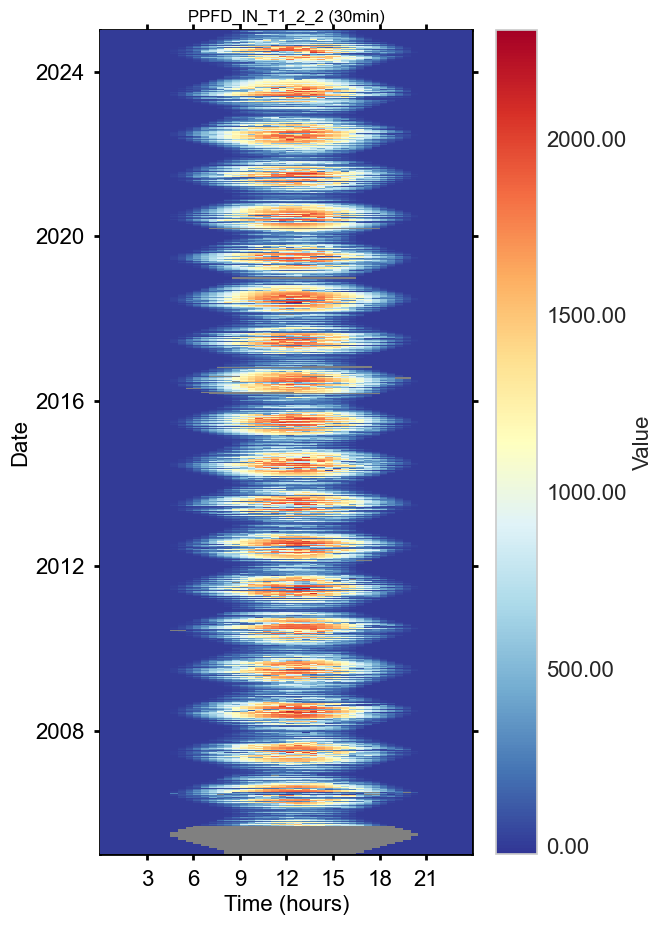

In [38]:
HeatmapDateTime(_df['PPFD_IN_T1_2_2']).plot()

### Fill

In [39]:
xgb = XGBoostTS(
    input_df=_df,
    target_col='PPFD_IN_T1_2_2',
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 350640.


In [40]:
xgb.reduce_features()
xgb.report_feature_reduction()


Feature reduction based on permutation importance ...
[0]	validation_0-rmse:325.23732	validation_1-rmse:325.23732
[1]	validation_0-rmse:229.11486	validation_1-rmse:229.11486
[2]	validation_0-rmse:162.29953	validation_1-rmse:162.29953
[3]	validation_0-rmse:116.22189	validation_1-rmse:116.22189
[4]	validation_0-rmse:84.81768	validation_1-rmse:84.81768
[5]	validation_0-rmse:63.89091	validation_1-rmse:63.89091
[6]	validation_0-rmse:50.34313	validation_1-rmse:50.34313
[7]	validation_0-rmse:41.93109	validation_1-rmse:41.93109
[8]	validation_0-rmse:36.89622	validation_1-rmse:36.89622
[9]	validation_0-rmse:33.88641	validation_1-rmse:33.88641
[10]	validation_0-rmse:32.15637	validation_1-rmse:32.15637
[11]	validation_0-rmse:31.06934	validation_1-rmse:31.06934
[12]	validation_0-rmse:30.32861	validation_1-rmse:30.32861
[13]	validation_0-rmse:29.85210	validation_1-rmse:29.85210
[14]	validation_0-rmse:29.38520	validation_1-rmse:29.38520
[15]	validation_0-rmse:29.10881	validation_1-rmse:29.10881
[16

In [41]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2005-01-01 00:45:00 and 2024-12-31 23:45:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:325.23732	validation_1-rmse:324.60019
[1]	validation_0-rmse:229.11486	validation_1-rmse:228.50045
[2]	validation_0-rmse:162.29953	validation_1-rmse:161.59285
[3]	validation_0-rmse:116.22189	validation_1-rmse:115.30561
[4]	validation_0-rmse:84.81769	validation_1-rmse:83.57315
[5]	validation_0-rmse:63.89092	validation_1-rmse:62.23451
[6]	validation_0-rmse:50.34317	validation_1-rmse:48.27809
[7]	validation_0-rmse:41.93144	validation_1-rmse:39.50949
[8]	validation_0-rmse:36.94021	validation_1-rmse:34.22487
[9]	validation_0-rmse:33.92395	validation_1-rmse:31.11069
[10]	validation_0-rmse:32.19361	validation_1-rmse:29.33318
[11]	validation_0-rmse:31.18447	validation_1-rmse:28.22811
[12]	validation_0-rmse:30.49785	validation_1-rmse:27.46488
[13]	validation_0-rmse:30.01732	validation

In [42]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()


Gap-filling using final model ...
>>> Using final model on all data to predict target PPFD_IN_T1_2_2 ...
>>> Using final model on all data to calculate permutation importance ...
>>> Calculating prediction scores based on all data predicting PPFD_IN_T1_2_2 ...
>>> Predicting target PPFD_IN_T1_2_2 where all features are available ... predicted 350640 records.
>>> Collecting results for final model ...
>>> Filling 7734 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable PPFD_IN_T1_2_2_gfXG ...
>>> Restoring original timestamp in results ...
>>> Combining predictions from full model and fallback model ...

GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (7734 values, PPFD_IN_T1_2_2_gfXG where flag=1) in comparison to observed targets (342906 values, PPFD_IN_T1_2_2).

## TARGET
- first timestamp:  2005-01-01 00:15:00
- last timestamp:  2024-12-31 23:45:00
- potential nu

### Results

In [43]:
results = xgb.gapfilling_df_
results

.PREDICTIONS_FULLMODEL  PPFD_IN_T1_2_2  .GAP_PREDICTIONS  FLAG_PPFD_IN_T1_2_2_gfXG_ISFILLED  PPFD_IN_T1_2_2_gfXG .PREDICTIONS_FALLBACK  .GAPFILLED_CUMULATIVE  .PREDICTIONS
TIMESTAMP_MIDDLE                                                                                                                                                                                
2005-01-01 00:15:00                0.466701             0.0               NaN                                  0                  0.0                  None           0.000000e+00      0.466701
2005-01-01 00:45:00                0.466701             0.0               NaN                                  0                  0.0                  None           0.000000e+00      0.466701
2005-01-01 01:15:00                0.466701             0.0               NaN                                  0                  0.0                  None           0.000000e+00      0.466701
2005-01-01 01:45:00                0.466701             0.0               NaN                                  0                  0.0                  None           0.000000e+00      0.466701
2005-01-01 02:15:00                0.466701             0.0               NaN                                  0                  0.0                  None           0.000000e+00      0.466701
...                                     ...             ...               ...                                ...                  ...                   ...                    ...           ...
2024-12-31 21:45:00                0.018580             0.0               NaN                                  0                  0.0                  None           9.850744e+07      0.018580
2024-12-31 22:15:00                0.018580             0.0               NaN                                  0                  0.0                  None           9.850744e+07      0.018580
2024-12-31 22:45:00                0.018580             0.0               NaN                                  0                  0.0                  None           9.850744e+07      0.018580
2024-12-31 23:15:00                0.018580             0.0               NaN                                  0                  0.0                  None           9.850744e+07      0.018580
2024-12-31 23:45:00                0.018580             0.0               NaN                                  0                  0.0                  None           9.850744e+07      0.018580

[350640 rows x 8 columns]

### Add to data

In [44]:
# Combine data
data_simple_2005_2024['PPFD_IN_T1_2_2'] = results['PPFD_IN_T1_2_2_gfXG'].copy()
data_simple_2005_2024['PPFD_IN_T1_2_2']

TIMESTAMP_MIDDLE
2005-01-01 00:15:00    0.0
2005-01-01 00:45:00    0.0
2005-01-01 01:15:00    0.0
2005-01-01 01:45:00    0.0
2005-01-01 02:15:00    0.0
                      ... 
2024-12-31 21:45:00    0.0
2024-12-31 22:15:00    0.0
2024-12-31 22:45:00    0.0
2024-12-31 23:15:00    0.0
2024-12-31 23:45:00    0.0
Freq: 30min, Name: PPFD_IN_T1_2_2, Length: 350640, dtype: float64

In [45]:
# Combine flags not necessary, because PPFD was not gapfilled before
data_simple_2005_2024['FLAG_PPFD_IN_T1_2_2_ISFILLED'] = results['FLAG_PPFD_IN_T1_2_2_gfXG_ISFILLED'].copy()
data_simple_2005_2024['FLAG_PPFD_IN_T1_2_2_ISFILLED']

TIMESTAMP_MIDDLE
2005-01-01 00:15:00    0
2005-01-01 00:45:00    0
2005-01-01 01:15:00    0
2005-01-01 01:45:00    0
2005-01-01 02:15:00    0
                      ..
2024-12-31 21:45:00    0
2024-12-31 22:15:00    0
2024-12-31 22:45:00    0
2024-12-31 23:15:00    0
2024-12-31 23:45:00    0
Freq: 30min, Name: FLAG_PPFD_IN_T1_2_2_ISFILLED, Length: 350640, dtype: int64

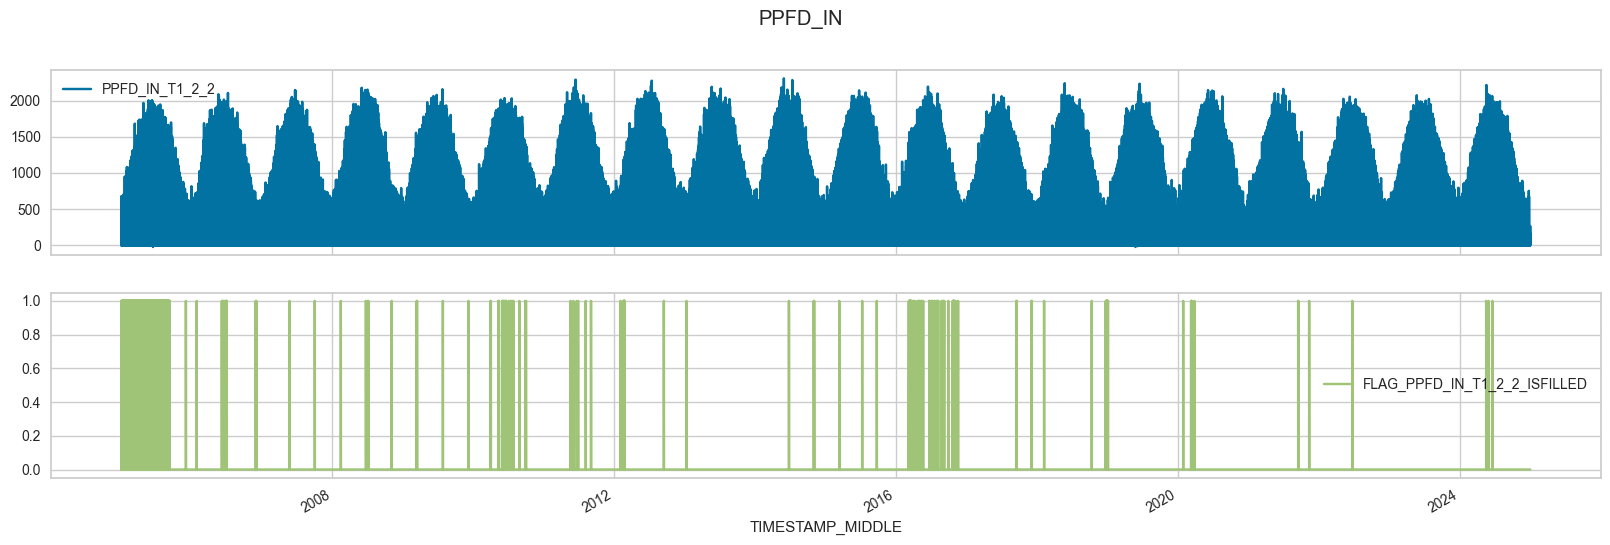

In [46]:
title = "PPFD_IN"
data_simple_2005_2024[['PPFD_IN_T1_2_2', 'FLAG_PPFD_IN_T1_2_2_ISFILLED']].plot(x_compat=True, title=title, subplots=True, figsize=(20, 6));

</br>

## Calculate VPD (kPa)

In [47]:
from diive.pkgs.createvar.vpd import calc_vpd_from_ta_rh

In [48]:
vpd = calc_vpd_from_ta_rh(df=data_simple_2005_2024, rh_col='RH_T1_2_1', ta_col='TA_T1_2_1')
vpd

TIMESTAMP_MIDDLE
2005-01-01 00:15:00    0.099893
2005-01-01 00:45:00    0.097606
2005-01-01 01:15:00    0.091683
2005-01-01 01:45:00    0.071157
2005-01-01 02:15:00    0.058333
                         ...   
2024-12-31 21:45:00    0.000011
2024-12-31 22:15:00    0.000011
2024-12-31 22:45:00    0.000011
2024-12-31 23:15:00    0.000010
2024-12-31 23:45:00    0.000010
Freq: 30min, Name: VPD, Length: 350640, dtype: float64

In [49]:
data_simple_2005_2024['VPD_T1_2_1'] = vpd

In [50]:
_df = pd.DataFrame()
_df['VPD_T1_2_1'] = data_simple_2005_2024[['VPD_T1_2_1']].copy()
_df['SW_IN_T1_2_1'] = data_simple_2005_2024[['SW_IN_T1_2_1']].copy()
_df['TA_T1_2_1'] = data_simple_2005_2024[['TA_T1_2_1']].copy()
_df

VPD_T1_2_1  SW_IN_T1_2_1  TA_T1_2_1
TIMESTAMP_MIDDLE                                        
2005-01-01 00:15:00    0.099893           0.0   1.566667
2005-01-01 00:45:00    0.097606           0.0   1.533333
2005-01-01 01:15:00    0.091683           0.0   1.566667
2005-01-01 01:45:00    0.071157           0.0   1.566667
2005-01-01 02:15:00    0.058333           0.0   1.500000
...                         ...           ...        ...
2024-12-31 21:45:00    0.000011           0.0  -1.919472
2024-12-31 22:15:00    0.000011           0.0  -2.104678
2024-12-31 22:45:00    0.000011           0.0  -2.089444
2024-12-31 23:15:00    0.000010           0.0  -2.355761
2024-12-31 23:45:00    0.000010           0.0  -2.578839

[350640 rows x 3 columns]

In [51]:
_df['VPD_T1_2_1'].isnull().sum()

np.int64(194)

### Fill

In [52]:
xgb = XGBoostTS(
    input_df=_df,
    target_col='VPD_T1_2_1',
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 350640.


In [53]:
xgb.reduce_features()
xgb.report_feature_reduction()


Feature reduction based on permutation importance ...
[0]	validation_0-rmse:0.38740	validation_1-rmse:0.38740
[1]	validation_0-rmse:0.30020	validation_1-rmse:0.30020
[2]	validation_0-rmse:0.24424	validation_1-rmse:0.24424
[3]	validation_0-rmse:0.20921	validation_1-rmse:0.20921
[4]	validation_0-rmse:0.18789	validation_1-rmse:0.18789
[5]	validation_0-rmse:0.17460	validation_1-rmse:0.17460
[6]	validation_0-rmse:0.16615	validation_1-rmse:0.16615
[7]	validation_0-rmse:0.16075	validation_1-rmse:0.16075
[8]	validation_0-rmse:0.15708	validation_1-rmse:0.15708
[9]	validation_0-rmse:0.15420	validation_1-rmse:0.15420
[10]	validation_0-rmse:0.15209	validation_1-rmse:0.15209
[11]	validation_0-rmse:0.15004	validation_1-rmse:0.15004
[12]	validation_0-rmse:0.14856	validation_1-rmse:0.14856
[13]	validation_0-rmse:0.14742	validation_1-rmse:0.14742
[14]	validation_0-rmse:0.14634	validation_1-rmse:0.14634
[15]	validation_0-rmse:0.14559	validation_1-rmse:0.14559
[16]	validation_0-rmse:0.14466	validation_1

In [54]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2005-01-01 00:45:00 and 2024-12-31 23:15:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:0.38740	validation_1-rmse:0.38547
[1]	validation_0-rmse:0.30020	validation_1-rmse:0.29905
[2]	validation_0-rmse:0.24424	validation_1-rmse:0.24400
[3]	validation_0-rmse:0.20921	validation_1-rmse:0.20968
[4]	validation_0-rmse:0.18789	validation_1-rmse:0.18911
[5]	validation_0-rmse:0.17460	validation_1-rmse:0.17628
[6]	validation_0-rmse:0.16615	validation_1-rmse:0.16826
[7]	validation_0-rmse:0.16075	validation_1-rmse:0.16308
[8]	validation_0-rmse:0.15708	validation_1-rmse:0.15961
[9]	validation_0-rmse:0.15420	validation_1-rmse:0.15676
[10]	validation_0-rmse:0.15209	validation_1-rmse:0.15476
[11]	validation_0-rmse:0.15004	validation_1-rmse:0.15266
[12]	validation_0-rmse:0.14856	validation_1-rmse:0.15121
[13]	validation_0-rmse:0.14742	validation_1-rmse:0.15016
[14]	validation_0-r

In [55]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()


Gap-filling using final model ...
>>> Using final model on all data to predict target VPD_T1_2_1 ...
>>> Using final model on all data to calculate permutation importance ...
>>> Calculating prediction scores based on all data predicting VPD_T1_2_1 ...
>>> Predicting target VPD_T1_2_1 where all features are available ... predicted 350640 records.
>>> Collecting results for final model ...
>>> Filling 194 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable VPD_T1_2_1_gfXG ...
>>> Restoring original timestamp in results ...
>>> Combining predictions from full model and fallback model ...

GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (194 values, VPD_T1_2_1_gfXG where flag=1) in comparison to observed targets (350446 values, VPD_T1_2_1).

## TARGET
- first timestamp:  2005-01-01 00:15:00
- last timestamp:  2024-12-31 23:45:00
- potential number of values: 350640 val

### Results

In [56]:
results = xgb.gapfilling_df_
results

.PREDICTIONS_FULLMODEL  VPD_T1_2_1  .GAP_PREDICTIONS  FLAG_VPD_T1_2_1_gfXG_ISFILLED  VPD_T1_2_1_gfXG .PREDICTIONS_FALLBACK  .GAPFILLED_CUMULATIVE  .PREDICTIONS
TIMESTAMP_MIDDLE                                                                                                                                                                    
2005-01-01 00:15:00                0.083435    0.099893               NaN                              0         0.099893                  None               0.099893      0.083435
2005-01-01 00:45:00                0.083435    0.097606               NaN                              0         0.097606                  None               0.197499      0.083435
2005-01-01 01:15:00                0.067558    0.091683               NaN                              0         0.091683                  None               0.289182      0.067558
2005-01-01 01:45:00                0.067558    0.071157               NaN                              0         0.071157                  None               0.360339      0.067558
2005-01-01 02:15:00                0.058768    0.058333               NaN                              0         0.058333                  None               0.418672      0.058768
...                                     ...         ...               ...                            ...              ...                   ...                    ...           ...
2024-12-31 21:45:00               -0.001123    0.000011               NaN                              0         0.000011                  None          109123.093210     -0.001123
2024-12-31 22:15:00               -0.002141    0.000011               NaN                              0         0.000011                  None          109123.093220     -0.002141
2024-12-31 22:45:00               -0.002141    0.000011               NaN                              0         0.000011                  None          109123.093231     -0.002141
2024-12-31 23:15:00               -0.002114    0.000010               NaN                              0         0.000010                  None          109123.093241     -0.002114
2024-12-31 23:45:00               -0.010980    0.000010               NaN                              0         0.000010                  None          109123.093251     -0.010980

[350640 rows x 8 columns]

### Add to data

In [57]:
# Combine data
data_simple_2005_2024['VPD_T1_2_1'] = results['VPD_T1_2_1_gfXG'].copy()
data_simple_2005_2024['VPD_T1_2_1']

TIMESTAMP_MIDDLE
2005-01-01 00:15:00    0.099893
2005-01-01 00:45:00    0.097606
2005-01-01 01:15:00    0.091683
2005-01-01 01:45:00    0.071157
2005-01-01 02:15:00    0.058333
                         ...   
2024-12-31 21:45:00    0.000011
2024-12-31 22:15:00    0.000011
2024-12-31 22:45:00    0.000011
2024-12-31 23:15:00    0.000010
2024-12-31 23:45:00    0.000010
Freq: 30min, Name: VPD_T1_2_1, Length: 350640, dtype: float64

In [58]:
# Combine flags not necessary, because PPFD was not gapfilled before
data_simple_2005_2024['FLAG_VPD_T1_2_1_ISFILLED'] = results['FLAG_VPD_T1_2_1_gfXG_ISFILLED'].copy()
data_simple_2005_2024['FLAG_VPD_T1_2_1_ISFILLED']

TIMESTAMP_MIDDLE
2005-01-01 00:15:00    0
2005-01-01 00:45:00    0
2005-01-01 01:15:00    0
2005-01-01 01:45:00    0
2005-01-01 02:15:00    0
                      ..
2024-12-31 21:45:00    0
2024-12-31 22:15:00    0
2024-12-31 22:45:00    0
2024-12-31 23:15:00    0
2024-12-31 23:45:00    0
Freq: 30min, Name: FLAG_VPD_T1_2_1_ISFILLED, Length: 350640, dtype: int64

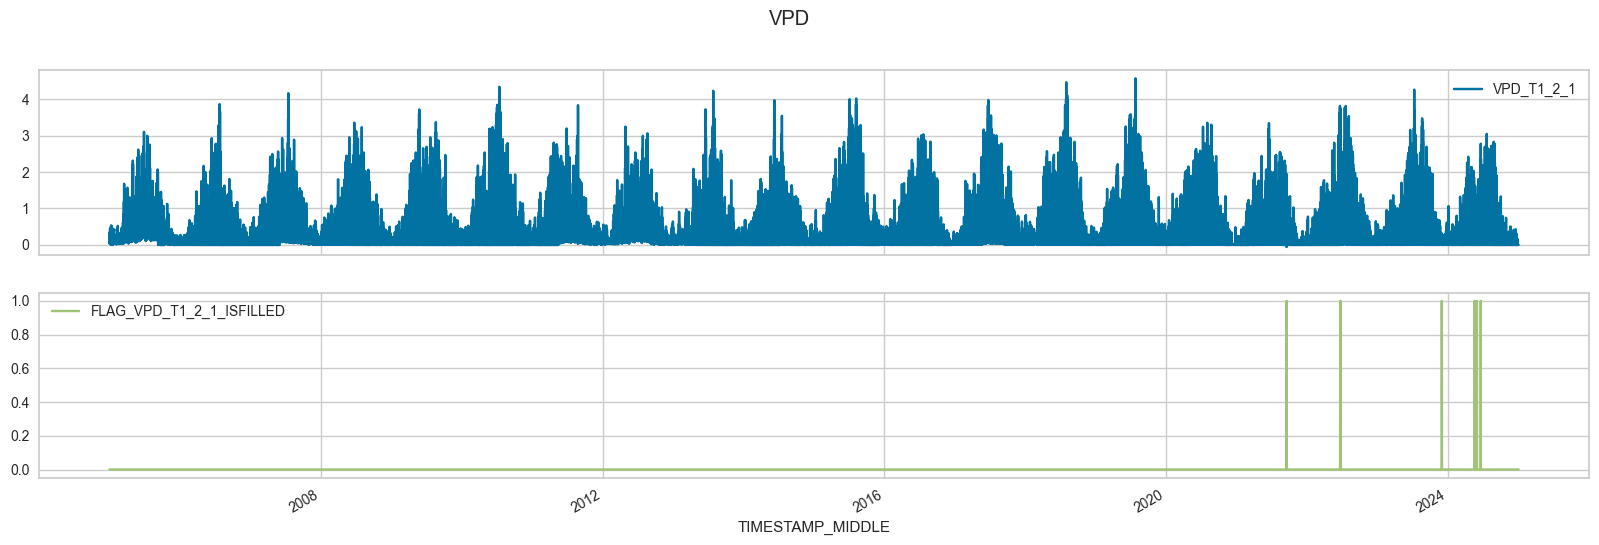

In [59]:
title = "VPD"
data_simple_2005_2024[['VPD_T1_2_1', 'FLAG_VPD_T1_2_1_ISFILLED']].plot(x_compat=True, title=title, subplots=True, figsize=(20, 6));

</br>

# **Plots**

In [60]:
_plot_df = data_simple_2005_2024.copy()
_plot_df = _plot_df.replace(-9999, np.nan)

## Time series plot

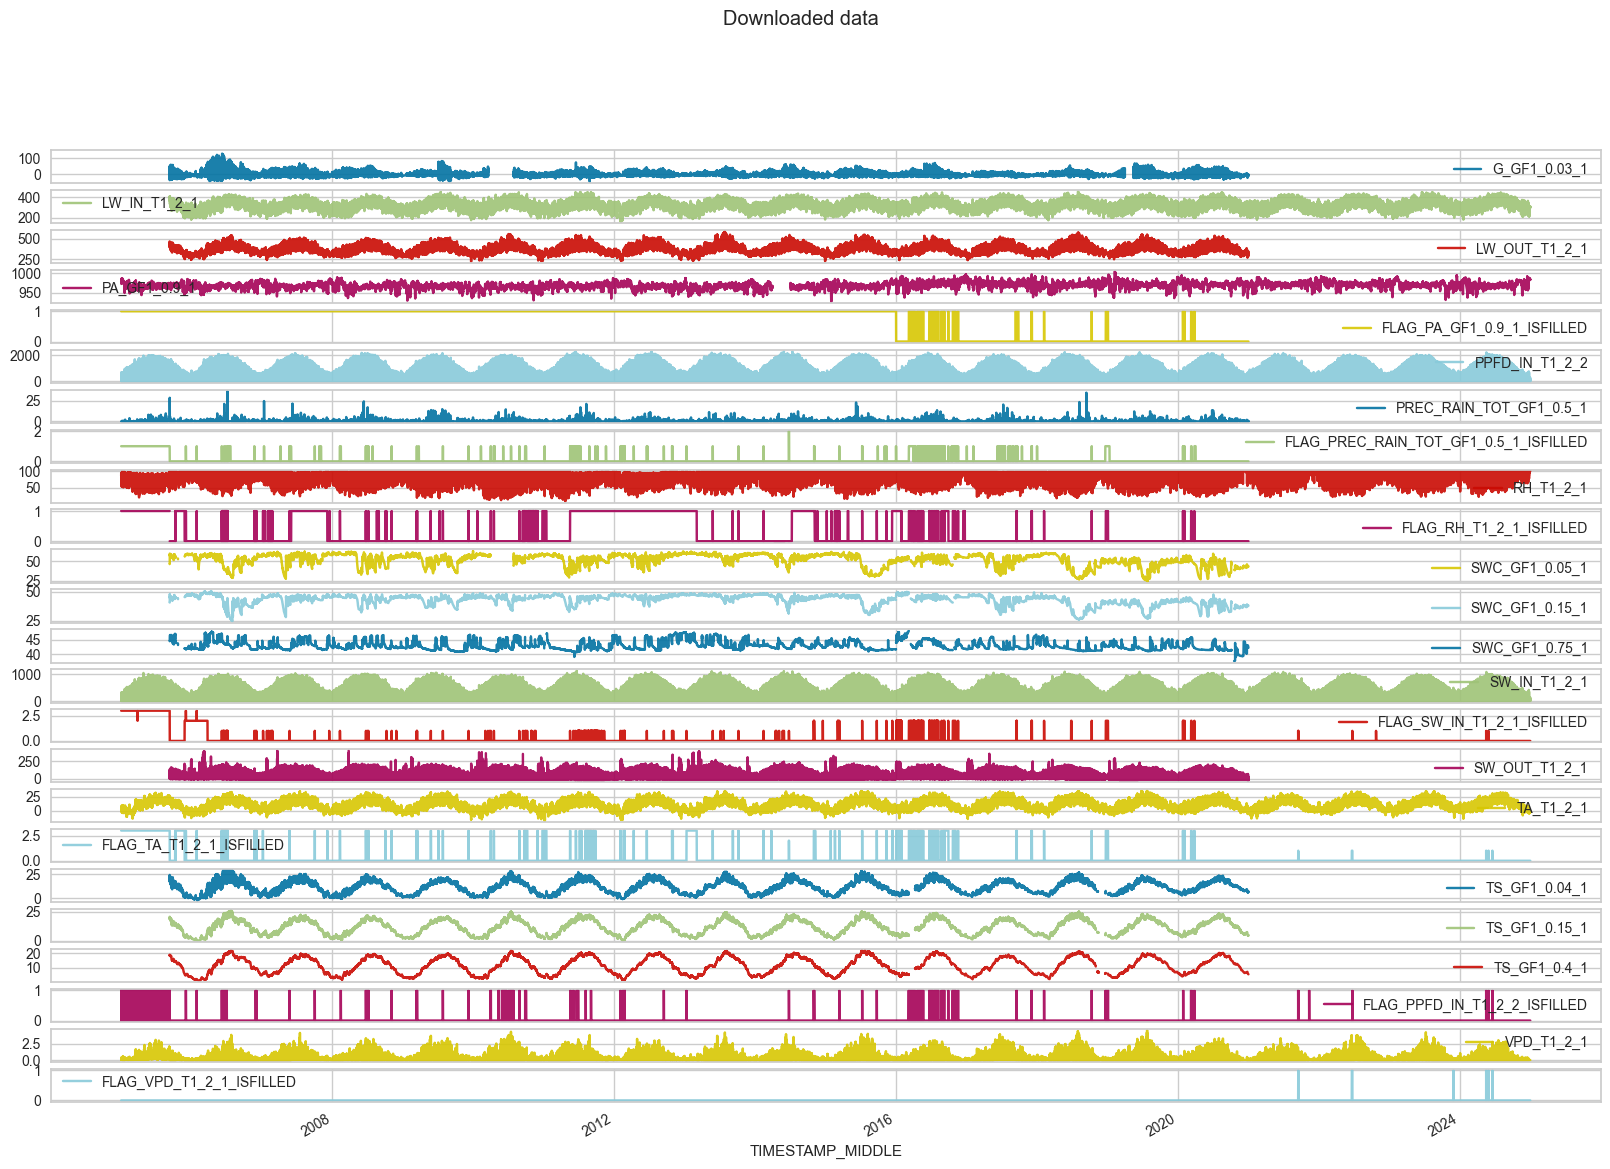

In [61]:
_plot_df.plot(subplots=True, figsize=(20, 14), title="Downloaded data", alpha=.9, x_compat=True);

## Heatmaps

L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\core\plotting\heatmap_base.py:190: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(facecolor='white', figsize=self.figsize)


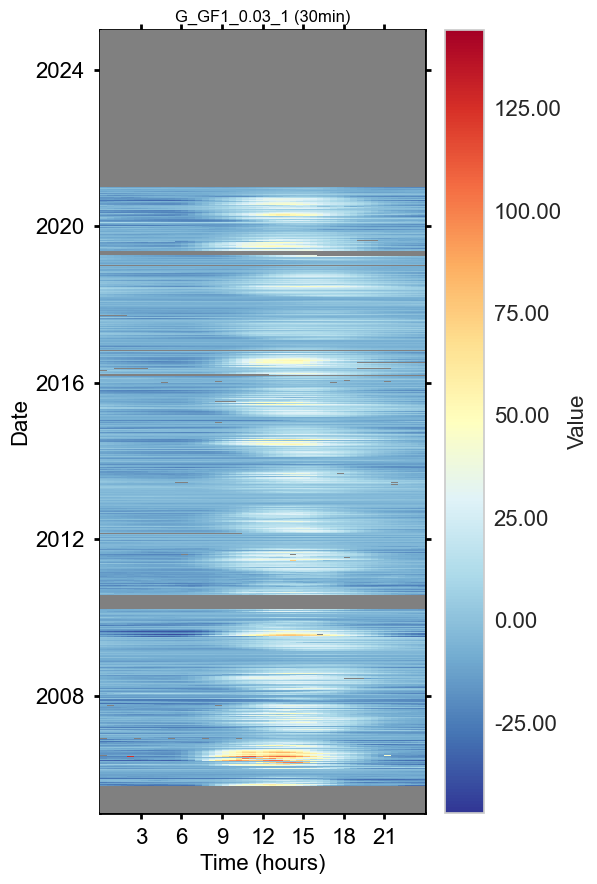

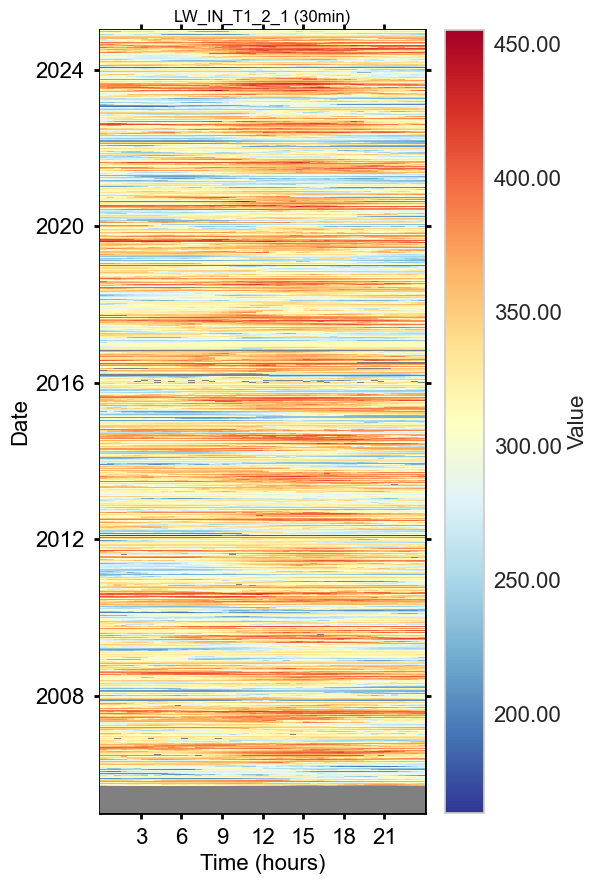

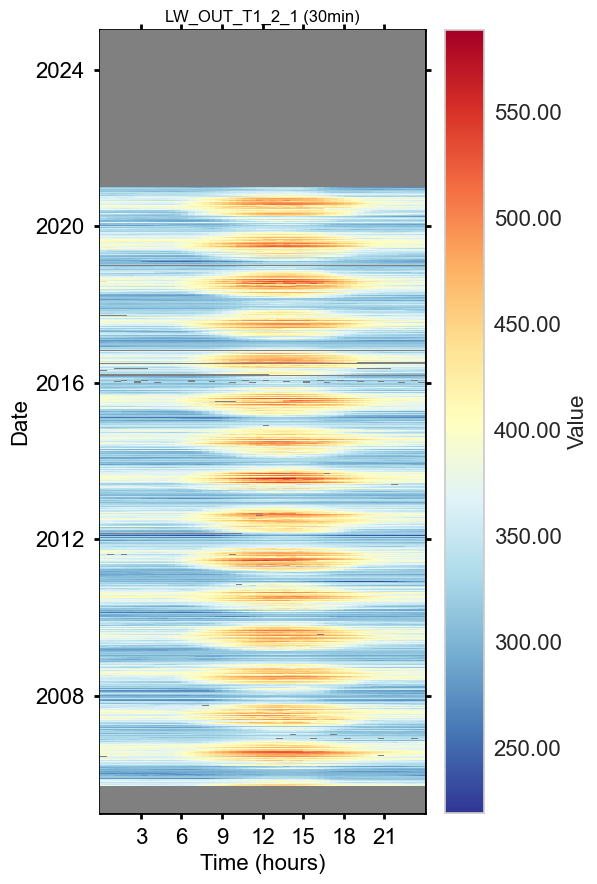

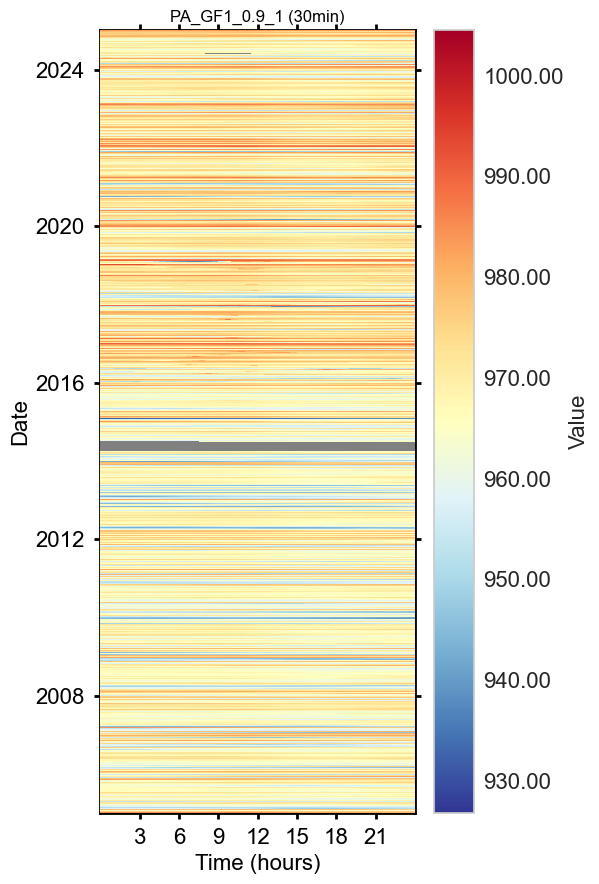

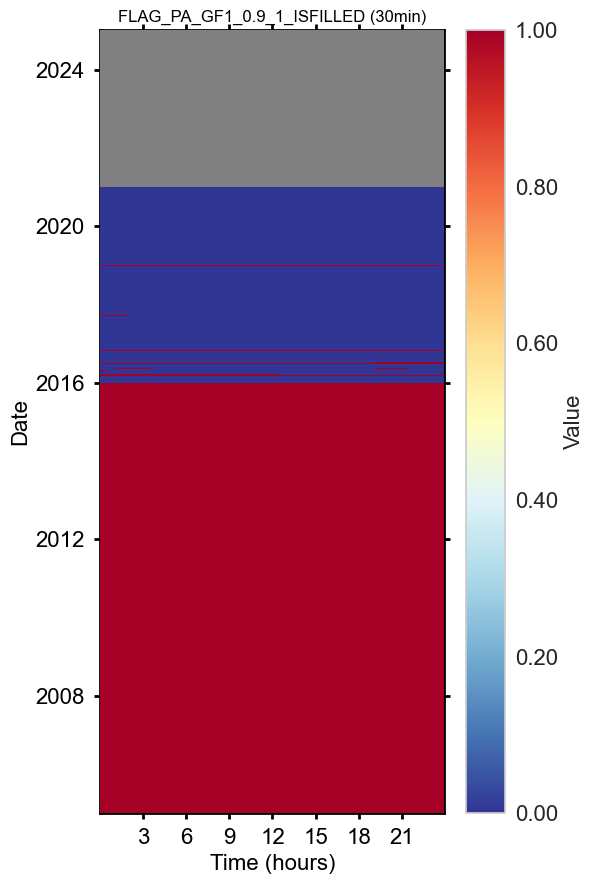

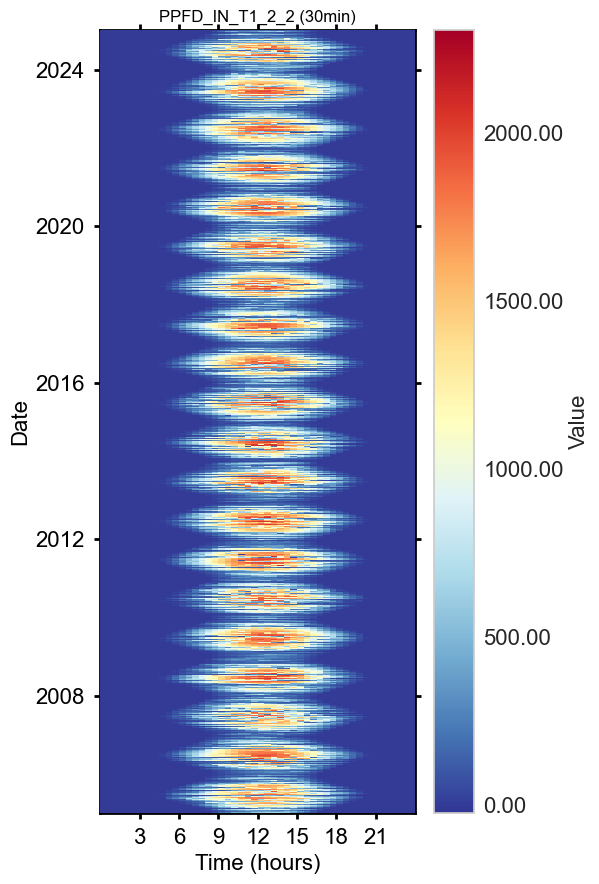

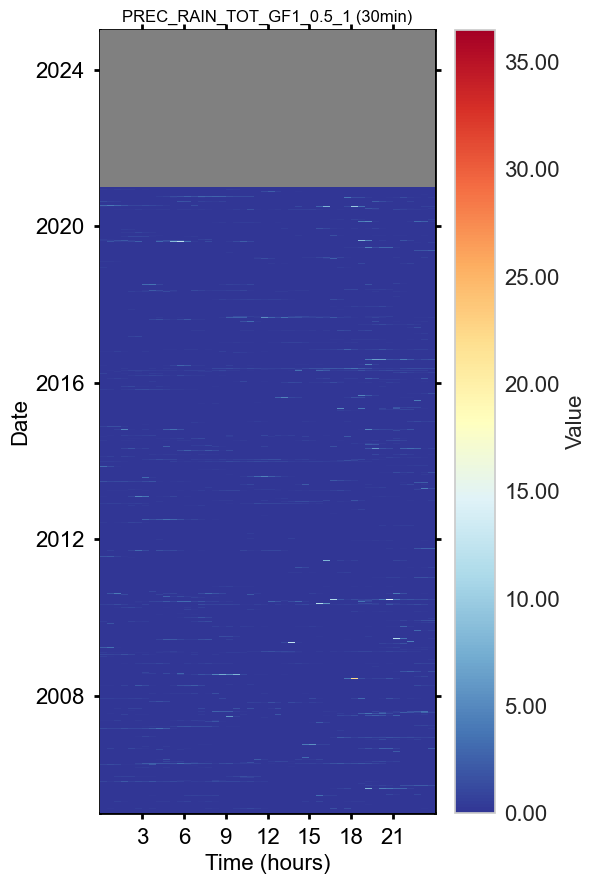

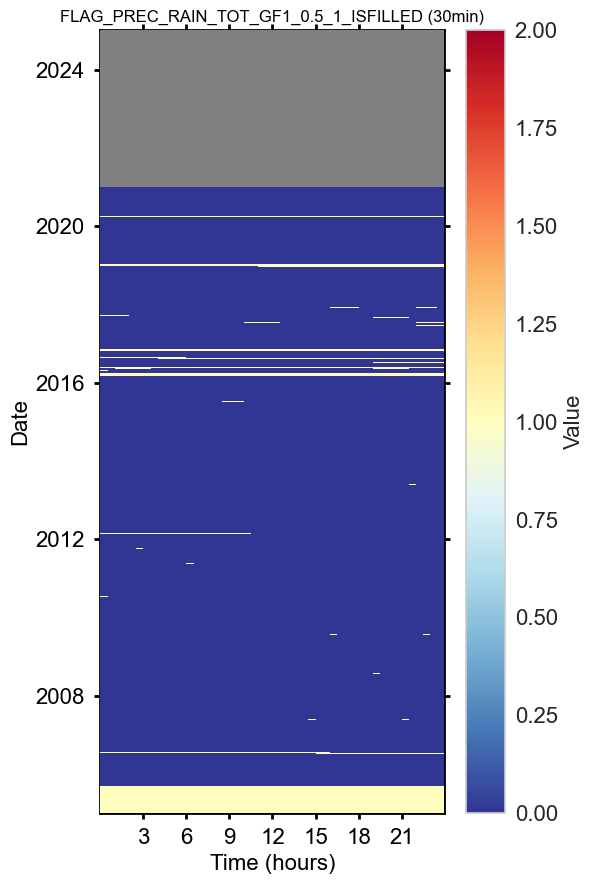

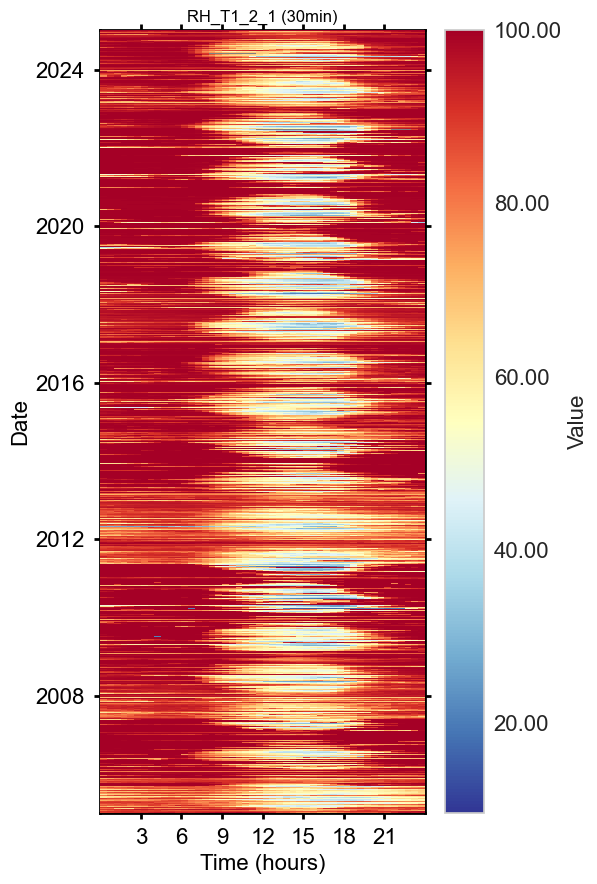

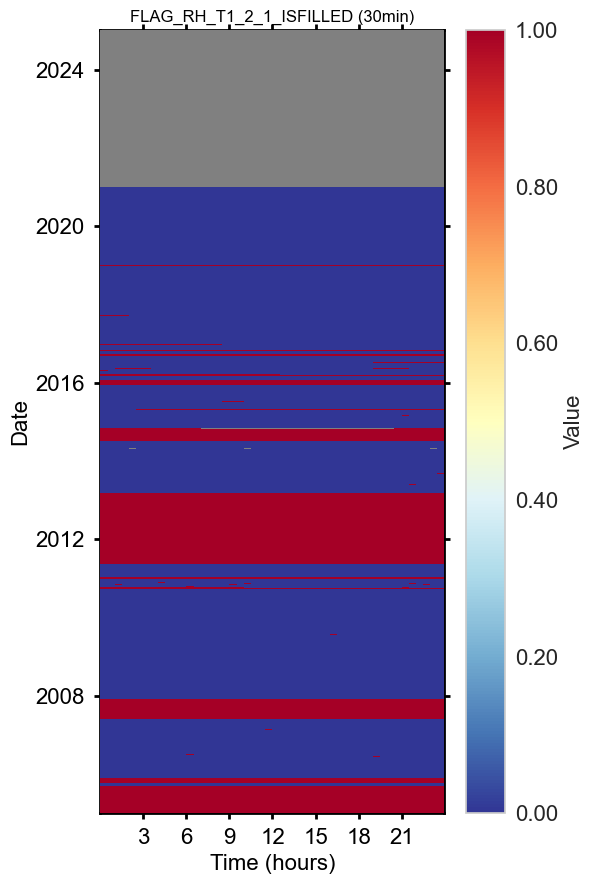

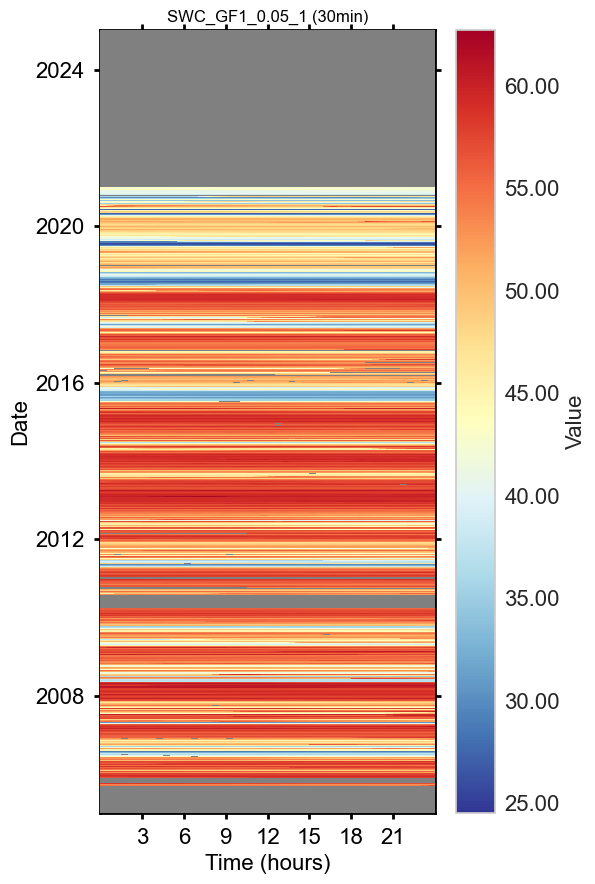

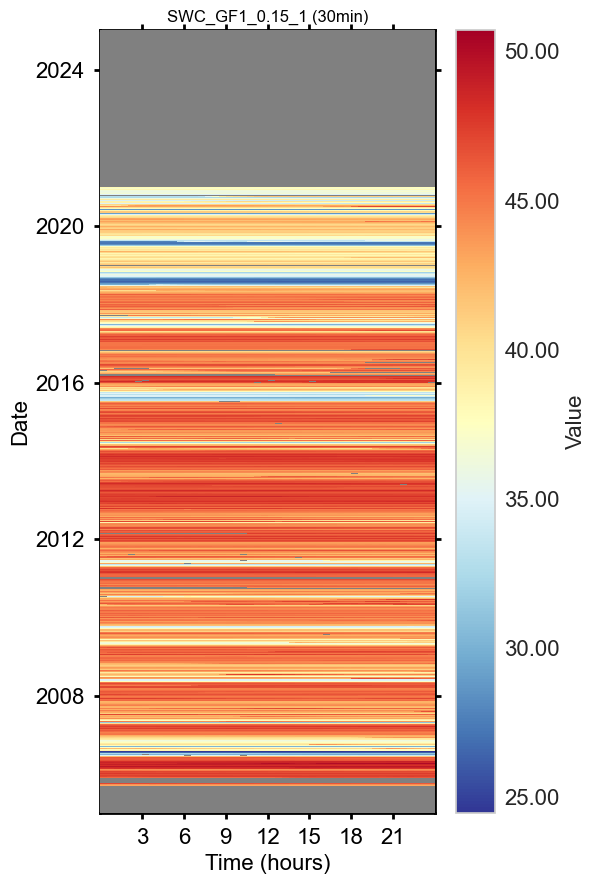

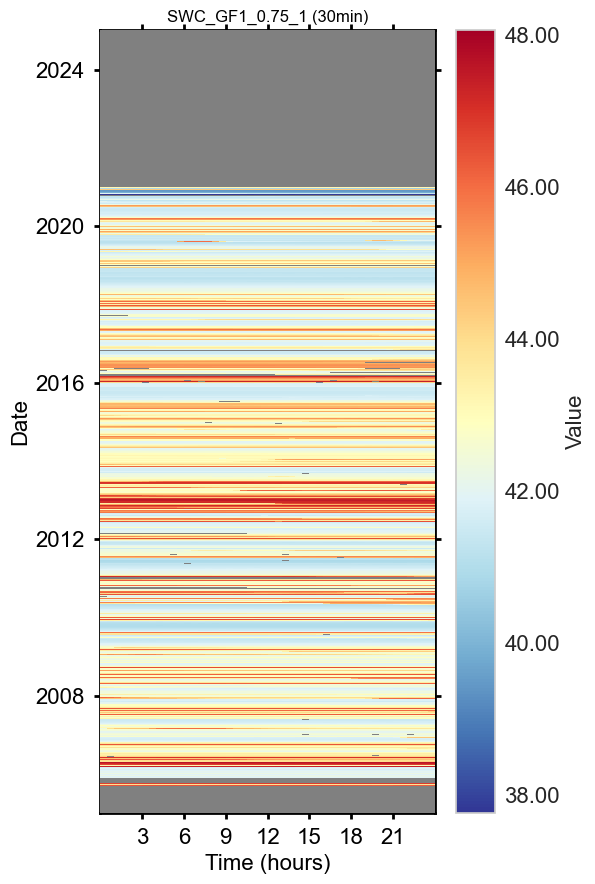

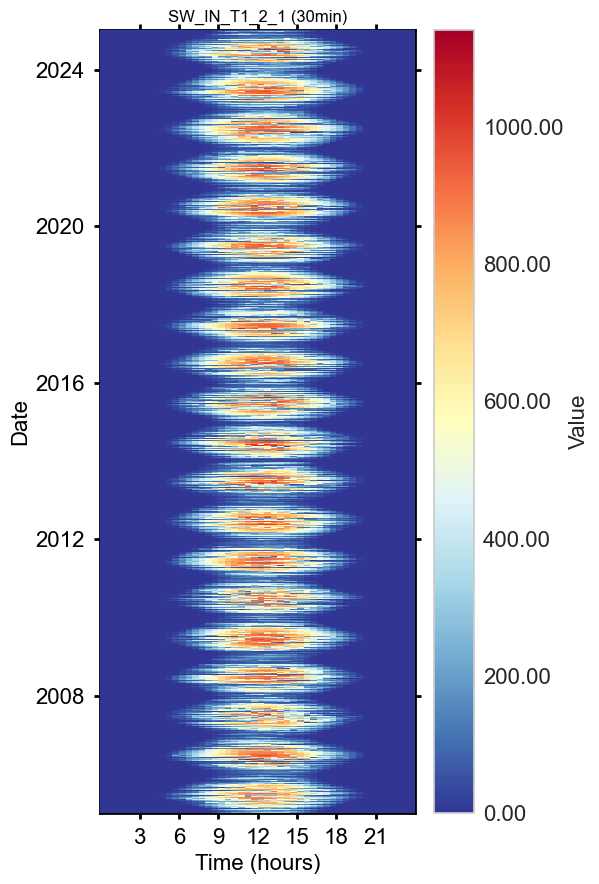

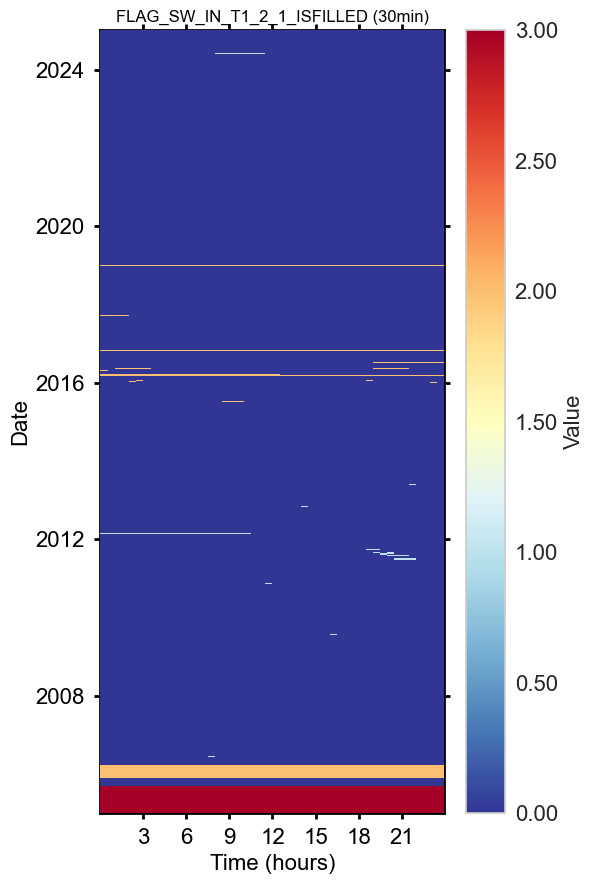

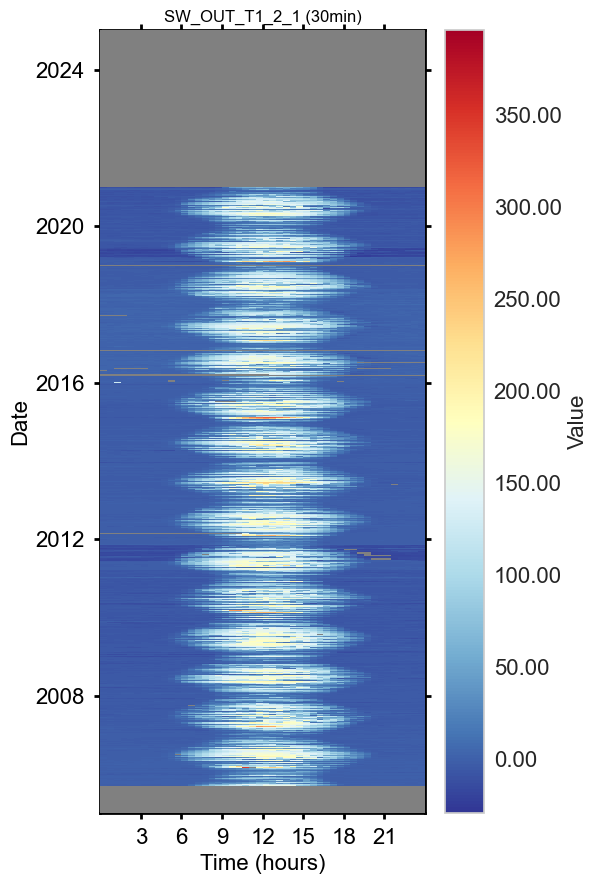

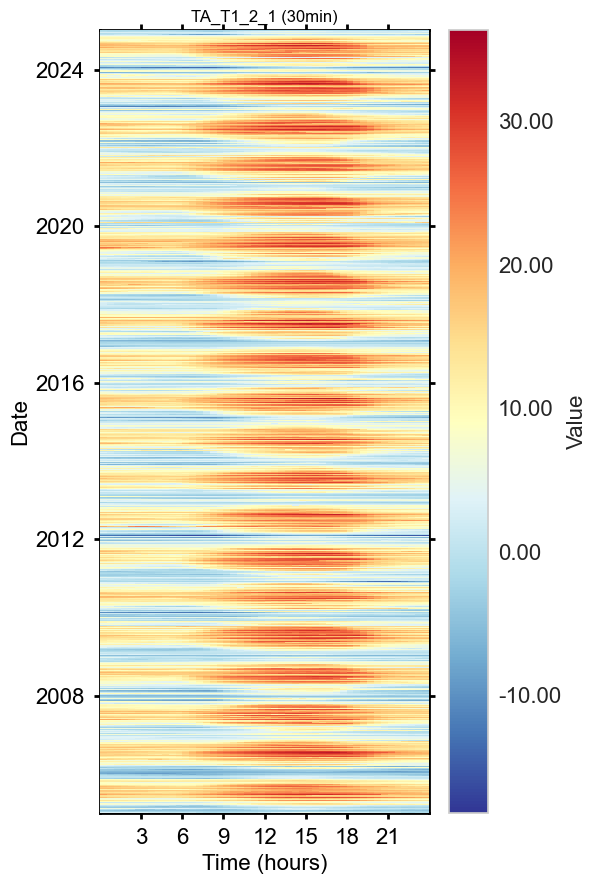

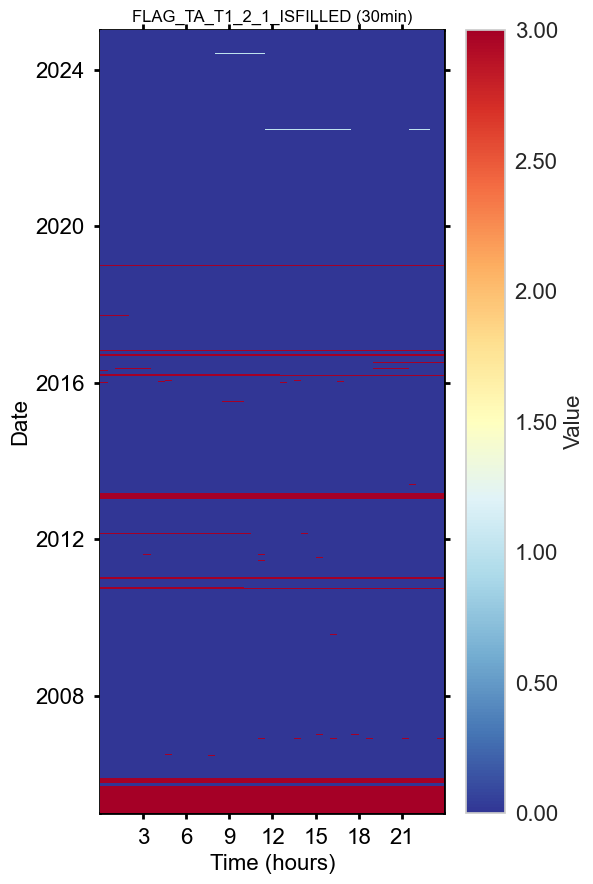

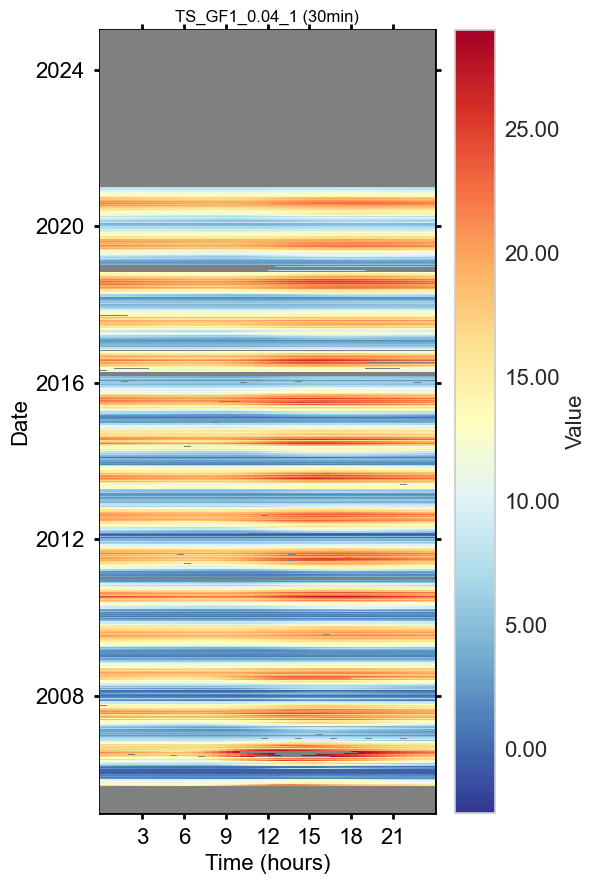

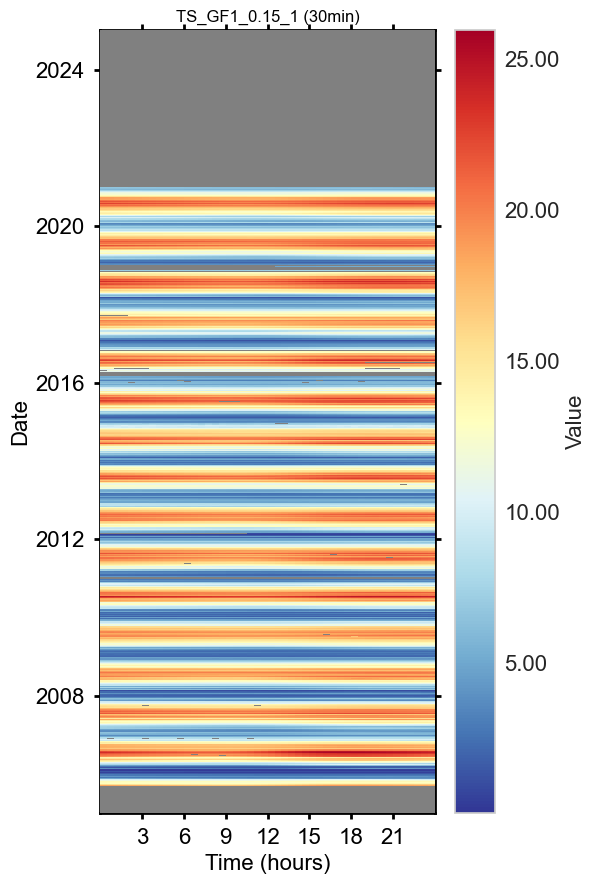

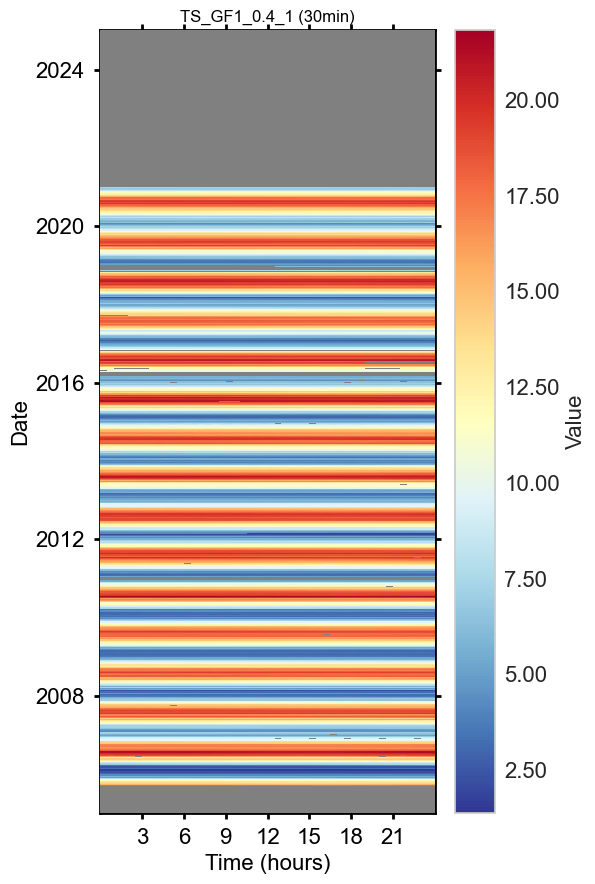

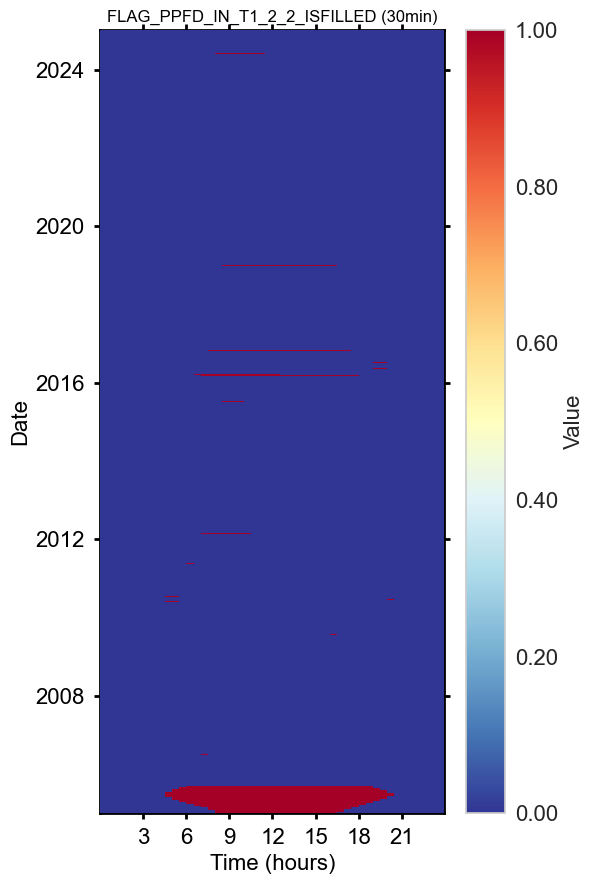

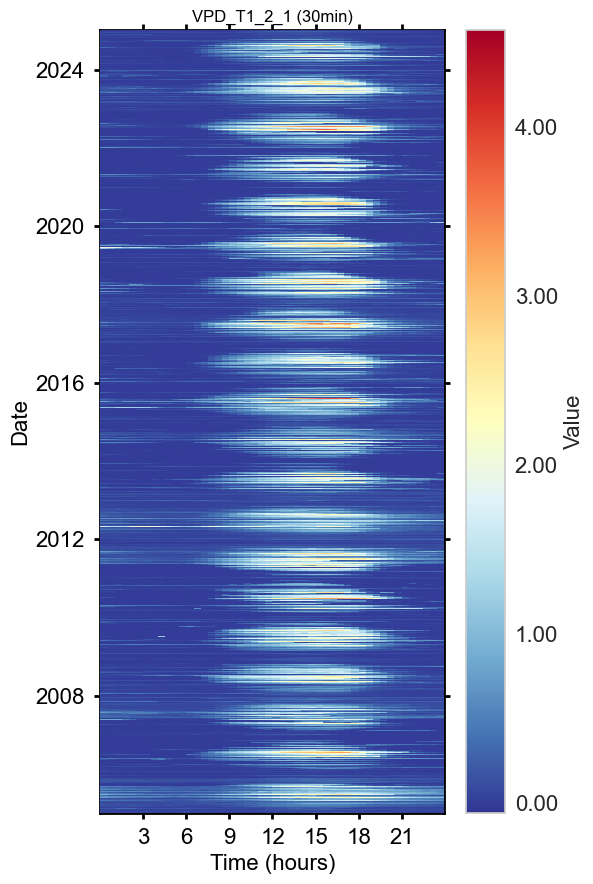

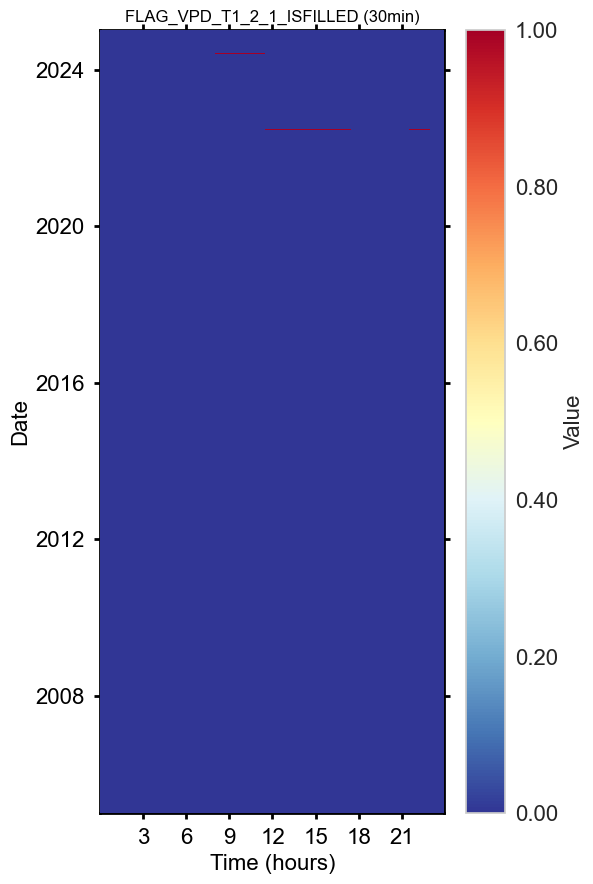

In [62]:
for col in _plot_df.columns:
    series = _plot_df[col]
    series.name = col
    HeatmapDateTime(series, figsize=(6, 9)).show()

</br>

# **Stats**

In [63]:
data_simple_2005_2024.describe().T

count        mean         std         min         25%         50%         75%          max
G_GF1_0.03_1                           257233.0   -1.294757   13.078049  -47.055000   -8.839500   -4.027900    3.322900   144.000000
LW_IN_T1_2_1                           334630.0  323.621286   44.292433  162.974472  296.259460  326.301376  355.175772   454.941700
LW_OUT_T1_2_1                          264726.0  363.862656   49.620005  219.459778  325.215393  357.583692  393.994850   588.454834
PA_GF1_0.9_1                           345963.0  968.040536    8.055630  926.800000  963.466667  968.410800  973.094743  1004.485000
FLAG_PA_GF1_0.9_1_ISFILLED             280512.0    0.697350    0.459406    0.000000    0.000000    1.000000    1.000000     1.000000
PPFD_IN_T1_2_2                         350640.0  280.936127  466.513839  -23.974247    0.000000    0.000000  370.503738  2306.300049
PREC_RAIN_TOT_GF1_0.5_1                280512.0    0.064690    0.408662    0.000000    0.000000    0.000000    0.000000    36.480904
FLAG_PREC_RAIN_TOT_GF1_0.5_1_ISFILLED  280512.0    0.063266    0.243457    0.000000    0.000000    0.000000    0.000000     2.000000
RH_T1_2_1                              350446.0   84.492494   18.126598    9.561100   73.433333   92.133333   99.721975   100.000000
FLAG_RH_T1_2_1_ISFILLED                280439.0    0.242998    0.428894    0.000000    0.000000    0.000000    0.000000     1.000000
SWC_GF1_0.05_1                         255743.0   50.799695    7.900669   24.511940   47.020676   53.084404   56.925919    62.706470
SWC_GF1_0.15_1                         261403.0   42.715561    4.602187   24.468729   40.653645   44.082874   45.981319    50.708080
SWC_GF1_0.75_1                         261394.0   43.008481    1.596751   37.764030   41.844761   42.524414   43.705841    48.056732
SW_IN_T1_2_1                           350640.0  142.267317  235.536372    0.000000    0.000000    0.000000  188.463783  1140.900024
FLAG_SW_IN_T1_2_1_ISFILLED             350640.0    0.150650    0.616569    0.000000    0.000000    0.000000    0.000000     3.000000
SW_OUT_T1_2_1                          265645.0   26.672217   49.826913  -29.716660   -3.722600    0.698370   39.070100   396.149994
TA_T1_2_1                              350640.0    9.988219    8.436331  -18.246000    3.304501    9.683236   15.975257    36.348891
FLAG_TA_T1_2_1_ISFILLED                350640.0    0.190378    0.730601    0.000000    0.000000    0.000000    0.000000     3.000000
TS_GF1_0.04_1                          261097.0   11.635724    6.528476   -2.576900    5.872834   11.853000   17.216000    29.000000
TS_GF1_0.15_1                          261812.0   11.692454    6.248735    0.045730    5.830100   11.827865   17.303924    25.957001
TS_GF1_0.4_1                           261914.0   11.546517    5.482197    1.378100    6.261362   11.589000   16.733999    21.813999
FLAG_PPFD_IN_T1_2_2_ISFILLED           350640.0    0.022057    0.146869    0.000000    0.000000    0.000000    0.000000     1.000000
VPD_T1_2_1                             350640.0    0.311211    0.518800   -0.057524    0.002725    0.079559    0.372177     4.574110
FLAG_VPD_T1_2_1_ISFILLED               350640.0    0.000553    0.023515    0.000000    0.000000    0.000000    0.000000     1.000000

</br>

# Keep 7 meteo variables

In [65]:
keepcols = [
    'LW_IN_T1_2_1',
    'PA_GF1_0.9_1',
    'FLAG_PA_GF1_0.9_1_ISFILLED',
    'PPFD_IN_T1_2_2',
    'FLAG_PPFD_IN_T1_2_2_ISFILLED',
    'VPD_T1_2_1',
    'FLAG_VPD_T1_2_1_ISFILLED',
    'SW_IN_T1_2_1',
    'FLAG_SW_IN_T1_2_1_ISFILLED',
    'TA_T1_2_1',
    'FLAG_TA_T1_2_1_ISFILLED',
    'RH_T1_2_1',
    'FLAG_RH_T1_2_1_ISFILLED'    
]
outdf = data_simple_2005_2024[keepcols].copy()
outdf

LW_IN_T1_2_1  PA_GF1_0.9_1  FLAG_PA_GF1_0.9_1_ISFILLED  PPFD_IN_T1_2_2  FLAG_PPFD_IN_T1_2_2_ISFILLED  VPD_T1_2_1  ...  SW_IN_T1_2_1  FLAG_SW_IN_T1_2_1_ISFILLED  TA_T1_2_1  FLAG_TA_T1_2_1_ISFILLED  RH_T1_2_1  FLAG_RH_T1_2_1_ISFILLED
TIMESTAMP_MIDDLE                                                                                                                       ...                                                                                                                  
2005-01-01 00:15:00           NaN    978.100000                         1.0             0.0                             0    0.099893  ...           0.0                         3.0   1.566667                      3.0  85.400000                      1.0
2005-01-01 00:45:00           NaN    977.933333                         1.0             0.0                             0    0.097606  ...           0.0                         3.0   1.533333                      3.0  85.700000                      1.0
2005-01-01 01:15:00           NaN    977.900000                         1.0             0.0                             0    0.091683  ...           0.0                         3.0   1.566667                      3.0  86.600000                      1.0
2005-01-01 01:45:00           NaN    977.833333                         1.0             0.0                             0    0.071157  ...           0.0                         3.0   1.566667                      3.0  89.600000                      1.0
2005-01-01 02:15:00           NaN    977.833333                         1.0             0.0                             0    0.058333  ...           0.0                         3.0   1.500000                      3.0  91.433333                      1.0
...                           ...           ...                         ...             ...                           ...         ...  ...           ...                         ...        ...                      ...        ...                      ...
2024-12-31 21:45:00    304.613900    983.370890                         NaN             0.0                             0    0.000011  ...           0.0                         0.0  -1.919472                      0.0  99.997990                      NaN
2024-12-31 22:15:00    303.039890    983.052160                         NaN             0.0                             0    0.000011  ...           0.0                         0.0  -2.104678                      0.0  99.997990                      NaN
2024-12-31 22:45:00    302.093633    982.851140                         NaN             0.0                             0    0.000011  ...           0.0                         0.0  -2.089444                      0.0  99.997990                      NaN
2024-12-31 23:15:00    302.217307    982.896827                         NaN             0.0                             0    0.000010  ...           0.0                         0.0  -2.355761                      0.0  99.997990                      NaN
2024-12-31 23:45:00    298.392973    982.856613                         NaN             0.0                             0    0.000010  ...           0.0                         0.0  -2.578839                      0.0  99.997990                      NaN

[350640 rows x 13 columns]

</br>

# **Save measured and gap-filled data to parquet**

In [66]:
OUTNAME = "16.1_CH-CHA_meteo7_gapfilled_2005-2024"
OUTPATH = r""
filepath = save_parquet(filename=OUTNAME, data=outdf, outpath=OUTPATH)
# outdf.to_csv(Path(OUTPATH) / f"{OUTNAME}.csv")

Saved file 16.1_CH-CHA_meteo7_gapfilled_2005-2024.parquet (0.196 seconds).


</br>

# **End of notebook**.

In [67]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2025-01-20 17:32:27
